<center>
    
#  Linear B-cell Epitopes Classification

</center>

## Abstract

This coursework focuses on developing a machine learning model to predict linear B-cell epitopes for Alphavirus, a genus of mosquito-borne viruses that includes pathogens like Chikungunya. The data used for this project was consolidated from various online databases, and the K Nearest Neighbor (KNN) model was selected for the task of detecting linear B cell epitopes of Alphavirus. The developed model was carefully tested and evaluated, achieving a roc score of 0.58 on the testing data. Additionally, the model's predictive capabilities were tested on Level 4 data, resulting in a significantly improved ROC AUC score of 0.69. The study demonstrates the potential of computational methods to predict epitopes and guide experimental procedures in vaccine and diagnostic test design.

## Introduction

Identification of B-cell epitopes in pathogenic organisms is critical for vaccine development and diagnostic test design, as these linear peptide segments, derived from pathogen proteins, can effectively induce protective immunity by triggering the production of antibodies via the binding of B cell receptors to specific epitopes(Larsen, Lund and Nielsen, 2006).

A machine learning model was developed in this coursework to predict Alphavirus epitopes, using computational methods to avoid laborious and resource-intensive experimental approaches for detecting immunogenic regions. Various combinations of data exploration, pre-processing, sampling, and machine learning models were experimented with to construct a pipeline that classifies the epitopes. After extensive analysis and experimentation, the K Nearest Neighbor (KNN) model was chosen to detect linear B cell epitopes of the Alphavirus. The pipeline achieved a ROC AUC score of 0.58 on the testing dataset and showed improved performance with a score of 0.69 on Level 4 data.

## Dataset

For the coursework, epitope data for the Alphavirus, which includes Chikungunya and other mosquito-borne viruses, was consolidated from various online databases, such as IEDB (IEDB.org: Free epitope database and prediction resource,2023), Genbank (GenBank Overview, 2023), and UniProtKB (UniProt, 2023), using research tools developed by the Aston University research team. As known epitopes for Alphaviruses are scarce, related virus data was also incorporated to predict epitopes. The data is structured into multiple levels and consists of information columns, 1293 feature columns, and a target class column. This project uses data from Level 1, 2, and 3, with initial exploration done on Level 1 and pipeline development on Level 2. The pipeline was then applied to process Level 3 data, and the model's performance was evaluated using the Level 4 dataset for testing purposes

## Methodology overview

The general overview of the method used for building the pipeline to predict epitopes is outlined below. Firstly, the data level 1 (df_training_level1.csv) was used for exploration of the data. As the coursework intimated, that the row dependency should be kept in mind always (Info_Cluster column should be grouped together always), the dataset was not sufficient as the class -1 had only one Info_cluster (204) which will not be suitable for modelling. Due to the limitations in the dataset of this level, proceeded to use level 2 for all the steps and pipeline creation. Thereafter, utilized level 3 to conform the pipeline performance. 

The general overview of the pipeline creation includes
   * Exploratory Data Analysis
   * Data Preprocessing
   * Feature Extraction
   * Preliminary Modelling
   * Imbalance classification by resampling
   * Hyperparameter tuning
   * Pipeline building
   

To facilitate manipulation and tracking of changes in data during the preliminary modeling and testing with the Level 2 dataset, separate data frames were created for each step.  The same code has been adopted for the Level 3 dataset. 
   
 
The model can be reproduced by following the highlighted **<font color=blue>steps</font>**.

##### Importing Necessary Libraries

In [2]:
# #Libraries that might need to be installed
# !pip install seaborn
# !pip install xgboost
# !pip install imblearn
# !pip install boruta

**<font color=blue>step 1</font>**

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold import TSNE
import warnings
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV,cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold,GroupKFold
from sklearn.feature_selection import mutual_info_classif,  SelectKBest, chi2, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef,make_scorer, roc_auc_score, roc_curve,confusion_matrix,ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, AdaBoostClassifier,  VotingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
import random
import datetime
from boruta import BorutaPy
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

Exploratory data analysis is carried out for analyzing and summarizing data sets to gain insights and identify patterns, relationships, and trends in the data. Python provides various methods and libraries to generate graphical and quantitative summaries of the data, which can be used to identify important features of the data, as well as potential problems like missing or inconsistent data, outliers, or imbalanced classes. By analyzing these summaries, informed decisions can be made about how to proceed with further analysis or modeling.

**<font color=blue>step 2</font>**

In [114]:
#Load data and display loaded data
df_main = pd.read_csv('df_training_level3.csv')
pd.set_option('display.max_columns', None)
df_main.head()

Info_PepID  Info_organism_id Info_protein_id  Info_pos Info_AA  \
0  NP_775663.1:2             11072     NP_775663.1         2       T   
1  NP_775663.1:2             11072     NP_775663.1         3       K   
2  NP_775663.1:2             11072     NP_775663.1         4       K   
3  NP_775663.1:2             11072     NP_775663.1         5       P   
4  NP_775663.1:2             11072     NP_775663.1         6       G   

  Info_pubmed_id Info_epitope_id Info_host_id Info_nPos Info_nNeg  \
0        8725101           64601         9606         2         1   
1        8725101           64601         9606         2         1   
2        8725101           64601         9606         2         1   
3        8725101           64601         9606         2         1   
4        8725101           64601         9606         2         1   

                                  Info_type      Info_window  Info_cluster  \
0  Epitope containing region/antigenic site  GGPKKTMTKKPGGPG             8   
1  Epitope containing region/antigenic site  GPKKTMTKKPGGPGK             8   
2  Epitope containing region/antigenic site  PKKTMTKKPGGPGKN             8   
3  Epitope containing region/antigenic site  KKTMTKKPGGPGKNR             8   
4  Epitope containing region/antigenic site  KTMTKKPGGPGKNRA             8   

   Class  feat_esm1b_0  feat_esm1b_1  feat_esm1b_2  feat_esm1b_3  \
0      1      0.115278      0.105343      0.256809      0.205551   
1      1      0.048915     -0.060122      0.054565      0.130224   
2      1      0.029908     -0.069993      0.144604      0.031607   
3      1     -0.017817      0.063682      0.196507      0.219516   
4      1      0.183947     -0.002784      0.185983      0.299326   

   feat_esm1b_4  feat_esm1b_5  feat_esm1b_6  feat_esm1b_7  feat_esm1b_8  \
0     -0.162306     -0.250113     -0.039983     -0.221369      0.016626   
1     -0.243280      0.032289     -0.035078      0.149056     -0.050518   
2     -0.157991      0.096214     -0.073147      0.150113     -0.123229   
3      0.010169      0.048974     -0.102324     -0.071483     -0.063823   
4     -0.256938      0.004182     -0.194807     -0.299934     -0.283545   

   feat_esm1b_9  feat_esm1b_10  feat_esm1b_11  feat_esm1b_12  feat_esm1b_13  \
0      0.105289       0.059885      -0.051816      -0.057010      -0.069828   
1     -0.056080       0.229829       0.108823      -0.151075       0.277442   
2     -0.060424       0.097726       0.112390      -0.093530       0.309241   
3     -0.034733       0.045129      -0.020568      -0.042546       0.091811   
4     -0.025699       0.001915      -0.096938       0.115930       0.097178   

   feat_esm1b_14  feat_esm1b_15  feat_esm1b_16  feat_esm1b_17  feat_esm1b_18  \
0       0.067001      -0.090702       0.644576      -0.152769       0.082127   
1      -0.065416       0.027009       0.834062      -0.074680      -0.042139   
2      -0.076096      -0.072296       0.742496      -0.164119      -0.062797   
3      -0.227348       0.064824       0.740591      -0.133582       0.024354   
4      -0.101307      -0.116988       0.715382      -0.214351       0.209073   

   feat_esm1b_19  feat_esm1b_20  feat_esm1b_21  feat_esm1b_22  feat_esm1b_23  \
0      -0.190023       0.074285       0.022002      -0.250581       0.072942   
1      -0.380881       0.108017       0.096606      -0.103887       0.362439   
2      -0.303906       0.202363       0.122323      -0.038013       0.322441   
3      -0.281321       0.141781       0.041033       0.073288       0.384873   
4      -0.107833       0.301740      -0.107868       0.157963       0.323984   

   feat_esm1b_24  feat_esm1b_25  feat_esm1b_26  feat_esm1b_27  feat_esm1b_28  \
0      -0.047608       0.409245      -0.226187      -0.275736       0.146188   
1      -0.032611       0.141882      -0.092266      -0.046156      -0.291495   
2      -0.046471       0.088327      -0.050355       0.005259      -0.159003   
3       0.102896       0.272625       0.132986       0.011409      -0.14

In the below section, there are a few helper functions that can be reused throughout the pipeline building process to explore the data 

**<font color=blue>step 3</font>**

In [115]:
def check_completeness(df):
    null_count = df.isnull().sum().sort_values(ascending=False)
    null_percents = df.isnull().sum() / len(df) * 100
    missing_values_df = pd.concat([null_count, null_percents], axis=1, keys=['Count', 'Percentage'])
    return missing_values_df

def row_completeness(df):
    null_rows = df.isnull().all(axis=1)
    num_null_rows = null_rows.sum()
    if num_null_rows > 0:
        print("Number of rows with all null values:", num_null_rows)
    else:
        print("There are no rows with all null values.")
        
def col_completeness(df):
    null_cols = df.isnull().all(axis=0)
    num_null_cols = null_cols.sum()
    if num_null_cols > 0:
        print("Columns with all null values:")
        print(null_cols[null_cols].index.tolist())
    else:
        print("There are no columns with all null values.")

#check if any column is homogenous
def find_homogeneous_columns(df):
    homogeneous_columns = []
    for column in df.columns:
        unique_values = df[column].unique()
        if len(unique_values) == 1:
            homogeneous_columns.append(column)
    return homogeneous_columns

def check_duplicates(df):
    duplicates = df[df.duplicated()]
    if duplicates.empty:
        print("No duplicates found.")
    else:
        print("Duplicates found:")
        print(len(duplicates))
        
        
def count_unique_outliers(df):
    threshold = 3
    outlier_list = df.apply(lambda x: np.where(np.abs((x - np.mean(x)) / np.std(x)) > threshold))
    unique_outliers = set()
    for col in outlier_list.columns:
        outliers = outlier_list[col][0]
        for outlier in outliers:
            unique_outliers.add(outlier)
    return len(unique_outliers)

def get_skewed_cols(df, threshold=1):
    skewness = df.skew()
    return skewness[(skewness > threshold) | (skewness < -threshold)].index.tolist()


def plot_box_plot(df, columns):
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20))
    for i, col in enumerate(columns):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_xlabel(col)
        axes[i].text(0.05, 0.95, col, transform=axes[i].transAxes,fontsize=12, va='top')
    plt.show()

def find_outliers_count_for_skewedcols(df, skewed_cols, multiplier=1.5):
    outlier_indices = {}
    total_outliers = 0
    for col in skewed_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper = q3 + multiplier*iqr
        lower = q1 - multiplier*iqr
        outliers = df.index[(df[col] > upper) | (df[col] < lower)]
        outlier_indices[col] = outliers
        outlier_count = len(outliers)
        total_outliers += outlier_count
    print("Outlier counts for each skewed column:")
    for col, outliers in outlier_indices.items():
        print(f"{col}: {len(outliers)}")
    print("Total number of outliers:", total_outliers)
    return outlier_indices

    
def plot_tsne(df):
    df_tsne = df.dropna()
    tsne = TSNE(n_components=2, random_state=42)
    df_tsne = tsne.fit_transform(df_tsne)

    # Plot the results
    plt.scatter(df_tsne[:, 0], df_tsne[:, 1])
    plt.show()

def min_max_variance(df,threshold):
    minima = df.min()
    maxima = df.max()
    centroid = np.array([minima.mean(), maxima.mean()])
    distances = np.sqrt((minima - centroid[0])**2 + (maxima - centroid[1])**2)
    
    # Filter for columns with a distance above the threshold
    large_distance_cols = distances[distances > threshold].index.tolist()
    return minima, maxima, large_distance_cols


def class_distribution(df, group, target):
    grouped = df.groupby(group)
    total_records = df.shape[0]
    for name, group in grouped:
        class_counts = group[target].value_counts(normalize=True)*100
        n_records = group.shape[0]
        cluster_percent = (n_records / total_records) * 100
        print(f"group {name} has {n_records} records and class balance:")
        print(class_counts)
       
    
def hist_plot(df,cols):
    fig, axs = plt.subplots(nrows=len(cols), figsize=(6, 6*len(cols)))
    for i, col in enumerate(cols):
        axs[i].hist(df[col], bins=10, edgecolor='black')
        axs[i].set_title(col)
    plt.tight_layout()
    plt.show()

In [60]:
#display number of observations, variables and variable types
df_main.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72663 entries, 0 to 72662
Data columns (total 1294 columns):
 #     Column            Dtype  
---    ------            -----  
 0     Info_PepID        object 
 1     Info_organism_id  int64  
 2     Info_protein_id   object 
 3     Info_pos          int64  
 4     Info_AA           object 
 5     Info_pubmed_id    object 
 6     Info_epitope_id   object 
 7     Info_host_id      object 
 8     Info_nPos         object 
 9     Info_nNeg         object 
 10    Info_type         object 
 11    Info_window       object 
 12    Info_cluster      int64  
 13    Class             int64  
 14    feat_esm1b_0      float64
 15    feat_esm1b_1      float64
 16    feat_esm1b_2      float64
 17    feat_esm1b_3      float64
 18    feat_esm1b_4      float64
 19    feat_esm1b_5      float64
 20    feat_esm1b_6      float64
 21    feat_esm1b_7      float64
 22    feat_esm1b_8      float64
 23    feat_esm1b_9      float64
 24    feat_esm1b_10     float6

The data is considered consistent, as all independent feature columns are of float type and the dependent class is represented as an integer. While there may be some object/int types in the Info columns, they can be disregarded as they are not used in the modeling process. To proceed with EDA, a new dataframe with only the columns used for modelling is created.

**<font color=blue>step 4</font>**

In [116]:
#create a new dataframe with feature for further EDA
df_feature = df_main.copy()
df_feature = df_feature.iloc[:, 14:]
df_feature.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72663 entries, 0 to 72662
Data columns (total 1280 columns):
 #     Column           Dtype  
---    ------           -----  
 0     feat_esm1b_0     float64
 1     feat_esm1b_1     float64
 2     feat_esm1b_2     float64
 3     feat_esm1b_3     float64
 4     feat_esm1b_4     float64
 5     feat_esm1b_5     float64
 6     feat_esm1b_6     float64
 7     feat_esm1b_7     float64
 8     feat_esm1b_8     float64
 9     feat_esm1b_9     float64
 10    feat_esm1b_10    float64
 11    feat_esm1b_11    float64
 12    feat_esm1b_12    float64
 13    feat_esm1b_13    float64
 14    feat_esm1b_14    float64
 15    feat_esm1b_15    float64
 16    feat_esm1b_16    float64
 17    feat_esm1b_17    float64
 18    feat_esm1b_18    float64
 19    feat_esm1b_19    float64
 20    feat_esm1b_20    float64
 21    feat_esm1b_21    float64
 22    feat_esm1b_22    float64
 23    feat_esm1b_23    float64
 24    feat_esm1b_24    float64
 25    feat_esm1b_25    f

##### Completeness check

In [326]:
check_completeness(df_feature)
#In level2 data, there are 521 columns with NULLs. Therfore all the feature columns have 10.53% NULL observations. 

Count  Percentage
feat_esm1b_0      1912    2.631325
feat_esm1b_1      1912    2.631325
feat_esm1b_858    1912    2.631325
feat_esm1b_857    1912    2.631325
feat_esm1b_856    1912    2.631325
...                ...         ...
feat_esm1b_425    1912    2.631325
feat_esm1b_424    1912    2.631325
feat_esm1b_423    1912    2.631325
feat_esm1b_422    1912    2.631325
feat_esm1b_1279   1912    2.631325

[1280 rows x 2 columns]

In [328]:
row_completeness(df_feature)
#There are 521 observations  with all columns NULL in it constituting to  10.53% of NULLs to the variables. 
#Therefore it would be wise to drop all the NULLs


Number of rows with all null values: 1912


In the level 2 data, it has been observed that there are 521 rows with NULL values. By checking the row completeness, it was identified that all 521 records are completely NULL. Similarly, in the level 3 file, there are 1912 rows with NULL values, and after checking the row completeness, it has been identified that all 1912 records are completely NULL. Hence, all the identified NULLs correspond to completely NULL rows and can be dropped while pre-processing the data

In [268]:
col_completeness(df_feature)

There are no columns with all null values.


As identified above, there are no completely NULL columns in bothe level 2 and level 3 files

In [269]:
df_feature.describe()

feat_esm1b_0  feat_esm1b_1  feat_esm1b_2  feat_esm1b_3  feat_esm1b_4  \
count  70751.000000  70751.000000  70751.000000  70751.000000  70751.000000   
mean       0.024815      0.173018      0.113880      0.027288     -0.082433   
std        0.174920      0.176281      0.181818      0.158430      0.160356   
min       -0.971916     -0.904106     -0.910500     -1.007923     -0.886783   
25%       -0.081343      0.067374     -0.005635     -0.065599     -0.184767   
50%        0.034574      0.172033      0.110035      0.033116     -0.084928   
75%        0.141719      0.273446      0.229405      0.128856      0.018662   
max        0.933674      1.169529      1.206786      0.947781      0.811858   

       feat_esm1b_5  feat_esm1b_6  feat_esm1b_7  feat_esm1b_8  feat_esm1b_9  \
count  70751.000000  70751.000000  70751.000000  70751.000000  70751.000000   
mean      -0.123585     -0.105387     -0.034119     -0.157909     -0.088024   
std        0.186805      0.177181      0.222676      0.185068      0.170760   
min       -1.206752     -1.256894     -1.147722     -1.495616     -1.196485   
25%       -0.242151     -0.214552     -0.189494     -0.254225     -0.185460   
50%       -0.122892     -0.102315     -0.047335     -0.149543     -0.073290   
75%       -0.006256      0.009932      0.119599     -0.048052      0.025838   
max        0.860858      0.771866      1.449602      0.738278      0.664098   

       feat_esm1b_10  feat_esm1b_11  feat_esm1b_12  feat_esm1b_13  \
count   70751.000000   70751.000000   70751.000000   70751.000000   
mean        0.124547       0.090605      -0.049234       0.162203   
std         0.172966       0.182935       0.190407       0.191531   
min        -0.957017      -0.647788      -0.731058      -0.924573   
25%         0.030960      -0.028947      -0.173415       0.043710   
50%         0.138680       0.085263      -0.066986       0.150714   
75%         0.233368       0.195862       0.051776       0.271538   
max         1.060558       1.305537       1.325340       1.223930   

       feat_esm1b_14  feat_esm1b_15  feat_esm1b_16  feat_esm1b_17  \
count   70751.000000   70751.000000   70751.000000   70751.000000   
mean        0.060702       0.051970       0.440265      -0.121240   
std         0.167813       0.174897       0.227967       0.172122   
min        -0.818815      -1.494226      -0.568159      -1.099655   
25%        -0.041554      -0.038138       0.292163      -0.220206   
50%         0.065230       0.060427       0.443055      -0.114401   
75%         0.163096       0.154383       0.591380      -0.015477   
max         0.991169       0.841433       1.337723       1.045511   

       feat_esm1b_18  feat_esm1b_19  feat_esm1b_20  feat_esm1b_21  \
count   70751.000000   70751.000000   70751.000000   70751.000000   
mean        0.063820      -0.059867       0.051697       0.091448   
std         0.164717       0.173381       0.190304       0.178632   
min        -0.895918      -0.818283      -1.017548      -0.881703   
25%        -0.032799      -0.168967      -0.069865      -0.024128   
50%         0.065163      -0.067545       0.047311       0.088308   
75%         0.163899       0.037743       0.161780       0.203818   
max         0.851497       1.050769       1.164567       1.040937   

       feat_esm1b_22  feat_esm1b_23  feat_esm1b_24  feat_esm1b_25  \
count   70751.000000   70751.000000   70751.000000   70751.000000   
mean        0.030190       0.219800       0.057679      -0.008858   
std         0.156592       0.196543       0.212327       0.228858   
min        -1.147365      -0.941851      -1.002416      -1.548014   
25%        -0.062710       0.098224      -0.075777      -0.119081   
50%         0.033984       0.227781       0.067927       0.006701   
75%         0.125802       0.351767       0.203543       0.136473   
max         1.118941       1.203255       1.041779       0.716015   

       feat_esm1b_26  feat_esm1b_27  feat_esm1b_28  feat_esm1b_29  \
count   70751.000000   707

##### Consistency check 

In [117]:
find_homogeneous_columns(df_feature)

[]

##### Duplicate check

In [271]:
check_duplicates(df_feature)

Duplicates found:
2642


There are no features that are consistent across both levels of the data. If there are columns that are consistent, they may not be particularly useful for modeling and could be excluded. Duplicates have been identified in both level 2 data. However, it is important to consider that some of the duplicates may be a result of null columns observed earlier

##### Outliers check

###### Z- Score method

In [272]:
count_unique_outliers(df_feature)

31453

###### Skewness

**<font color=blue>step 5</font>**

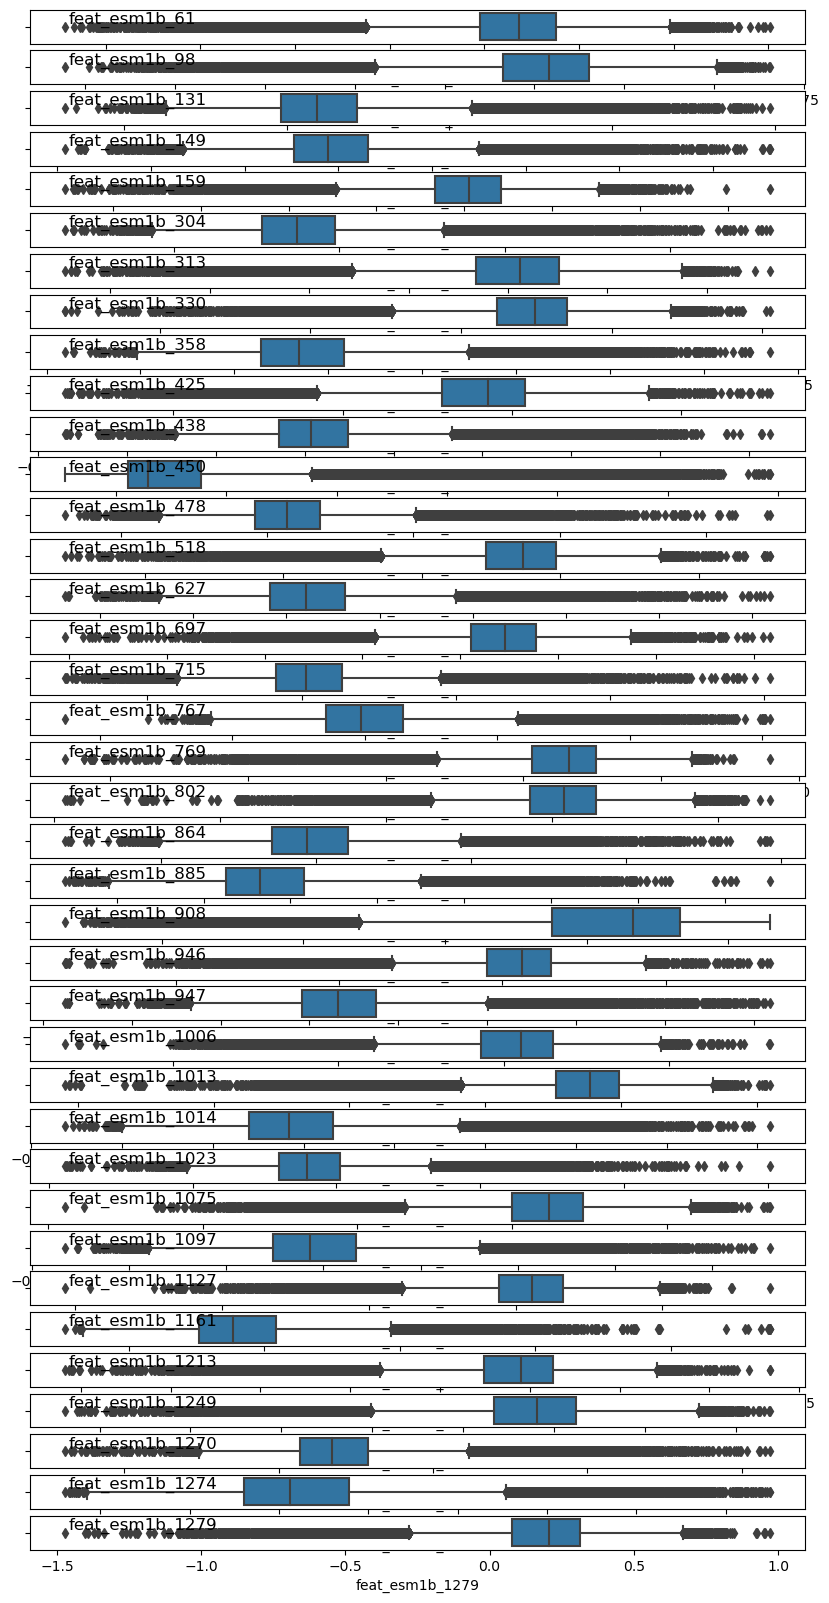

In [118]:
skewed_cols =get_skewed_cols(df_feature)
plot_box_plot(df_feature,skewed_cols)

**<font color=blue>step 6</font>**

In [119]:
# Find the outliers in each skewed column using the box plot method
outlier_counts = find_outliers_count_for_skewedcols(df_feature, skewed_cols, 3)
#the skewed cols have over 100 records each in the columns with high skewness
outlier_counts

Outlier counts for each skewed column:
feat_esm1b_61: 589
feat_esm1b_98: 449
feat_esm1b_131: 477
feat_esm1b_149: 374
feat_esm1b_159: 359
feat_esm1b_304: 412
feat_esm1b_313: 460
feat_esm1b_330: 460
feat_esm1b_358: 286
feat_esm1b_425: 247
feat_esm1b_438: 704
feat_esm1b_450: 5310
feat_esm1b_478: 434
feat_esm1b_518: 592
feat_esm1b_627: 370
feat_esm1b_697: 407
feat_esm1b_715: 395
feat_esm1b_767: 244
feat_esm1b_769: 800
feat_esm1b_802: 270
feat_esm1b_864: 250
feat_esm1b_885: 343
feat_esm1b_908: 294
feat_esm1b_946: 572
feat_esm1b_947: 354
feat_esm1b_1006: 369
feat_esm1b_1013: 973
feat_esm1b_1014: 334
feat_esm1b_1023: 392
feat_esm1b_1075: 361
feat_esm1b_1097: 281
feat_esm1b_1127: 286
feat_esm1b_1161: 228
feat_esm1b_1213: 576
feat_esm1b_1249: 410
feat_esm1b_1270: 525
feat_esm1b_1274: 274
feat_esm1b_1279: 723
Total number of outliers: 21184


{'feat_esm1b_61': Int64Index([ 2551,  3117,  3118,  3119,  3120,  3121,  4271,  4272,  4275,
              4276,
             ...
             70888, 70890, 71819, 71851, 71853, 72066, 72229, 72231, 72233,
             72309],
            dtype='int64', length=589),
 'feat_esm1b_98': Int64Index([   47,    50,    52,  2540,  3111,  3114,  3125,  3126,  3128,
              3463,
             ...
             66814, 66815, 67012, 68458, 68459, 68673, 68675, 69514, 70909,
             71022],
            dtype='int64', length=449),
 'feat_esm1b_131': Int64Index([ 3439,  4270,  4271,  4275,  4338,  5230,  5232,  5234,  5238,
              5241,
             ...
             69263, 69271, 72127, 72137, 72214, 72224, 72225, 72229, 72230,
             72241],
            dtype='int64', length=477),
 'feat_esm1b_149': Int64Index([   49,    51,  3105,  3106,  3109,  3111,  5192,  5195,  5322,
              5353,
             ...
             71080, 71805, 71810, 71819, 71825, 71849, 71850, 71853

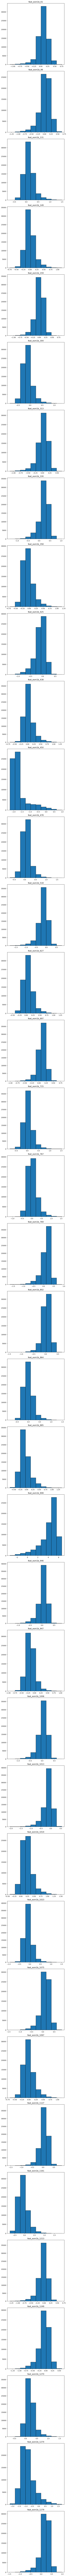

In [275]:
cols = list(outlier_counts.keys())
hist_plot(df_feature,cols)


##### t-SNE method

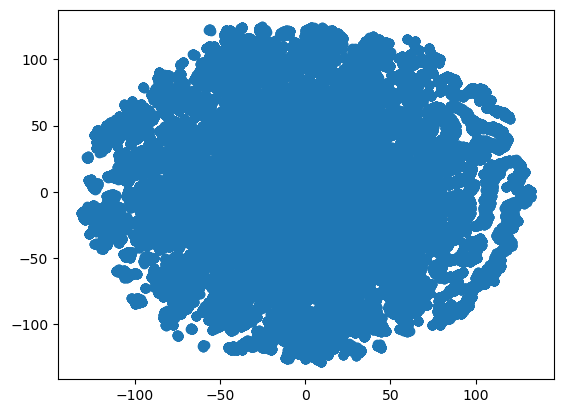

In [276]:
# Perform t-SNE on the data
plot_tsne(df_feature)


##### Min-Max plotting

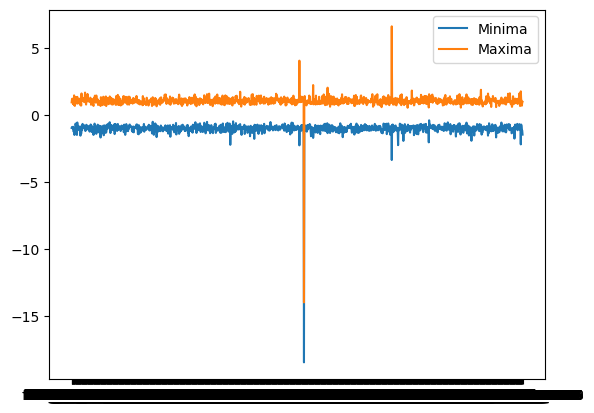

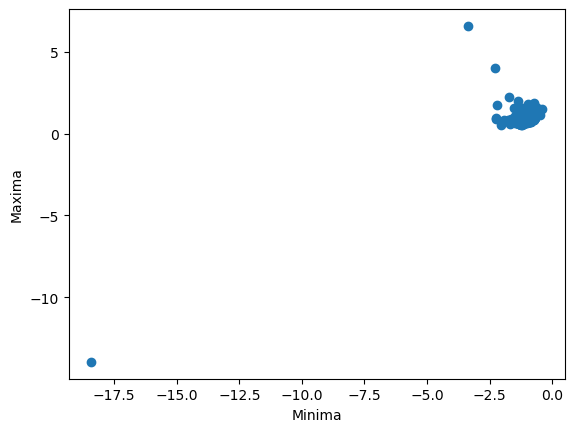

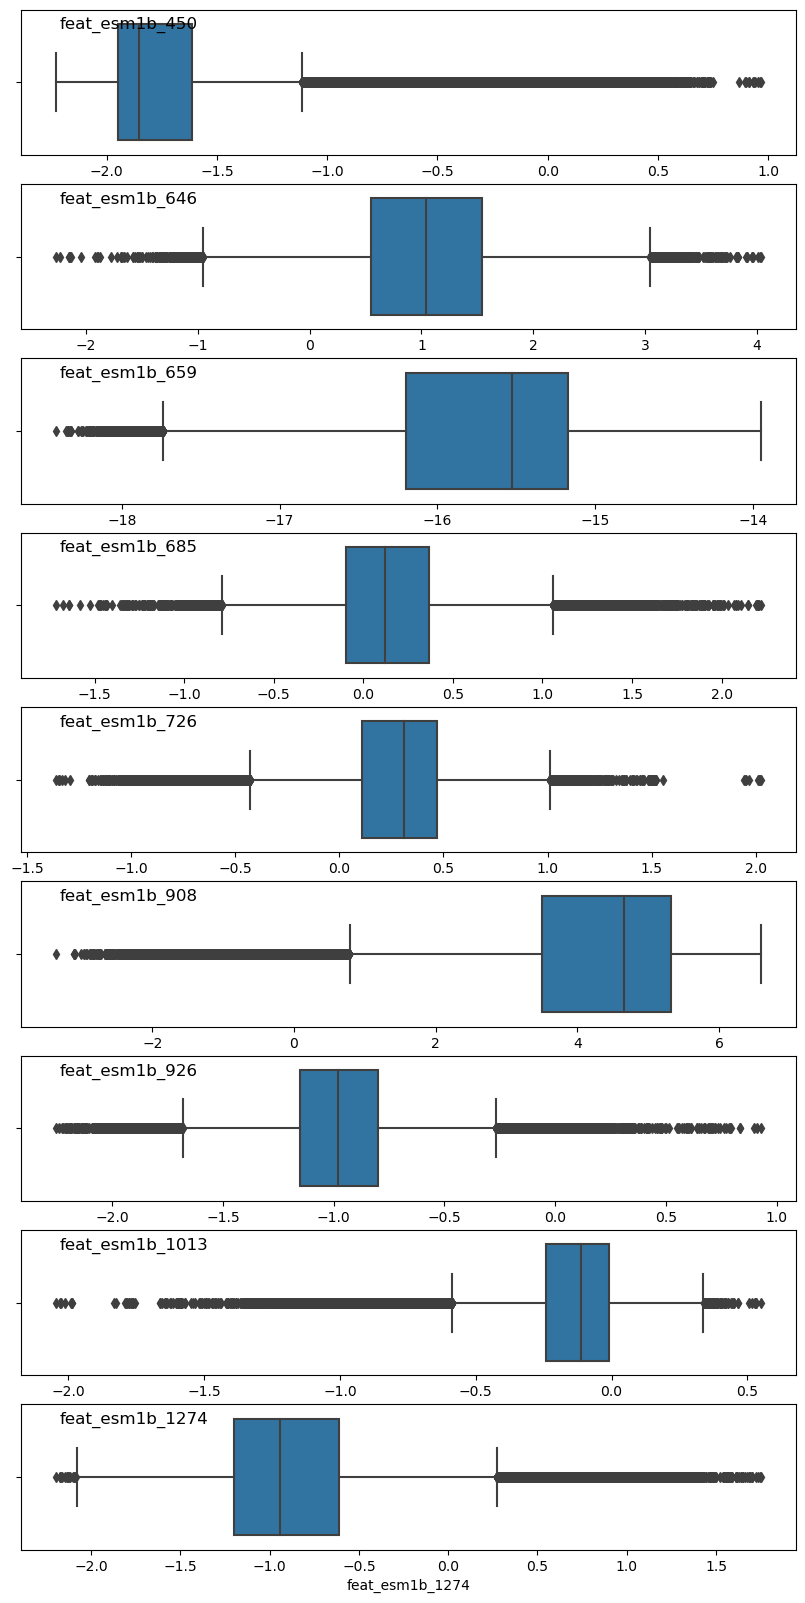

In [277]:
minima, maxima, large_distance_cols= min_max_variance(df_feature,1)
    
# plot min and max vectors
plt.plot(minima, label='Minima')
plt.plot(maxima, label='Maxima')
plt.legend()
plt.show()

# plot min and max vectors against each other
plt.scatter(minima, maxima)
plt.xlabel('Minima')
plt.ylabel('Maxima')
plt.show()

plot_box_plot(df_feature,large_distance_cols)
#on closer examination 908 has the biggest range, but the datapoints are very scattered and there are a large no of observations 
#near the maxima i.e outlier end of box plot > 100 records

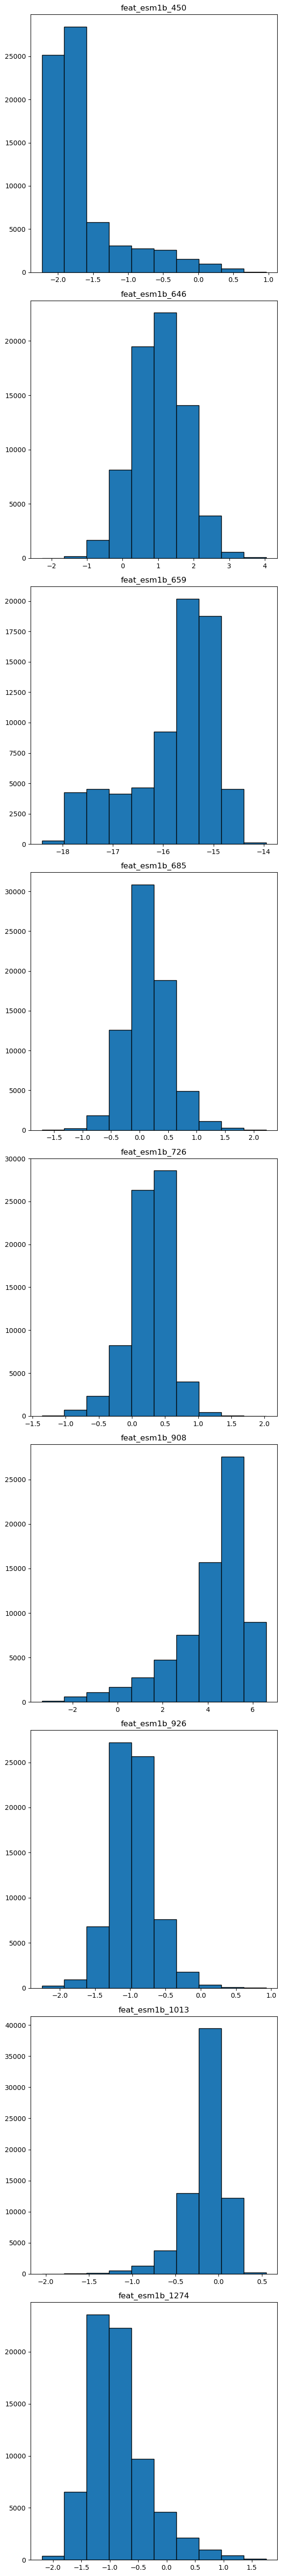

In [278]:
large_distance_cols
hist_plot(df_feature,large_distance_cols)

['feat_esm1b_450', 'feat_esm1b_908', 'feat_esm1b_1013', 'feat_esm1b_1274']


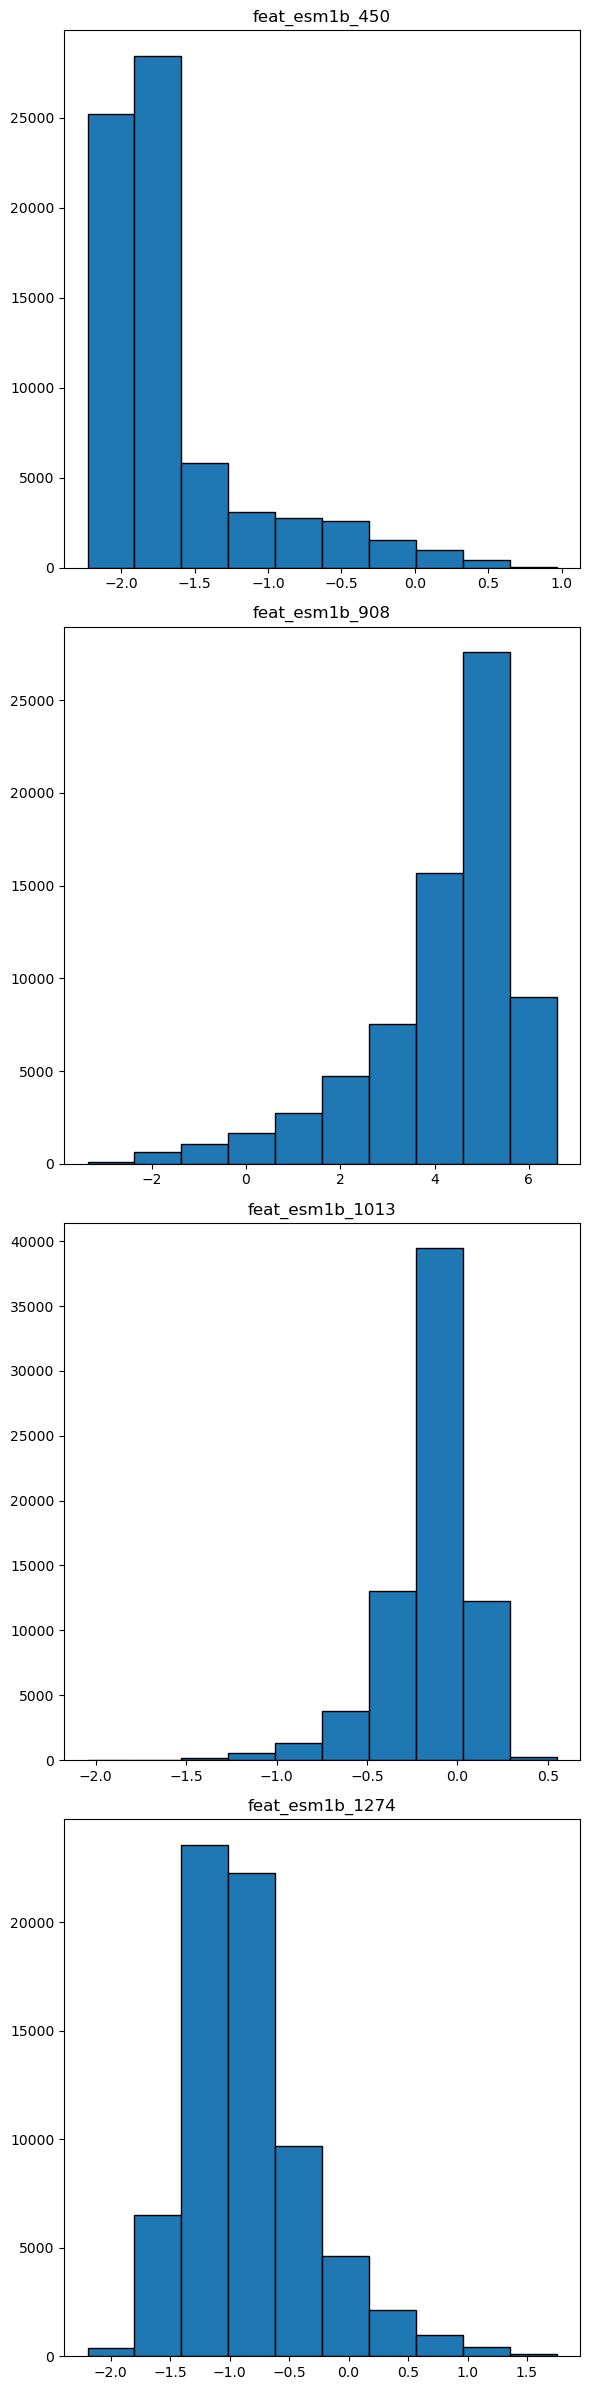

In [279]:
#comparing the skewed_col outliers along with min max variance outlier
col=[]
for item in large_distance_cols:
    if item in outlier_counts:
        col.append(item)
print(col)
hist_plot(df_feature,col)

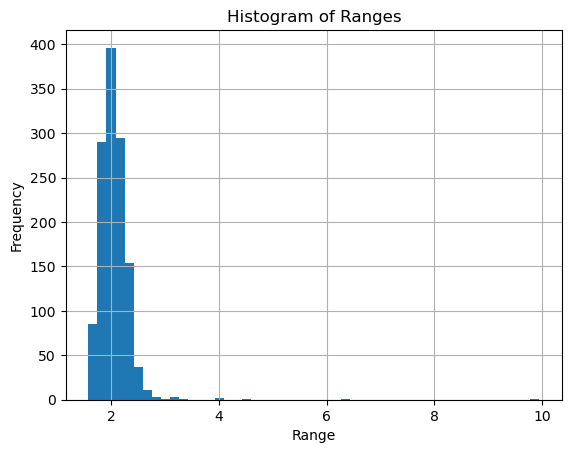

In [280]:
ranges = maxima - minima
ranges.hist(bins=50)
plt.xlabel('Range')
plt.ylabel('Frequency')
plt.title('Histogram of Ranges')
plt.show()

There are numerous outliers identified using Z-score method(with threshold of 3), plotting skewness, t-SNE, Min-Max plotting and Range plotting. Some of these were plotted for closer investiagation. It should be noted that some of the outliers may be from the same row. Therefore, the actual number of rows affected may be significantly lower than what is observed.

##### Check for class distribution

As stated in the methodology, the distribution of classes in level 1 data was observed during this stage. This observation led to the decision of using level 2 data for further data processing. Despite being unbalanced, level 2 and 3 data contain numerous Info_clusters that have both classes represented.

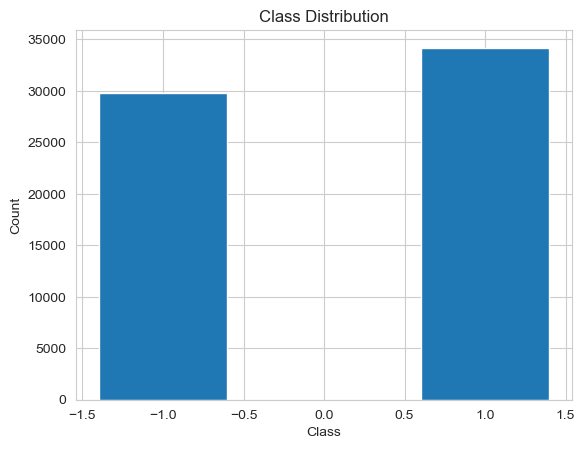

In [81]:
class_counts = df_main['Class'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [79]:
class_distribution(df_main,'Info_cluster','Class')

group 8 has 41362 records and class balance:
 1    60.799768
-1    39.200232
Name: Class, dtype: float64
group 28 has 17407 records and class balance:
-1    57.465387
 1    42.534613
Name: Class, dtype: float64
group 34 has 1142 records and class balance:
-1    94.570928
 1     5.429072
Name: Class, dtype: float64
group 35 has 1406 records and class balance:
-1    92.958748
 1     7.041252
Name: Class, dtype: float64
group 36 has 244 records and class balance:
-1    75.0
 1    25.0
Name: Class, dtype: float64
group 44 has 27 records and class balance:
-1    100.0
Name: Class, dtype: float64
group 50 has 81 records and class balance:
1    100.0
Name: Class, dtype: float64
group 62 has 523 records and class balance:
 1    64.627151
-1    35.372849
Name: Class, dtype: float64
group 150 has 564 records and class balance:
-1    50.177305
 1    49.822695
Name: Class, dtype: float64
group 198 has 43 records and class balance:
 1    72.093023
-1    27.906977
Name: Class, dtype: float64
group 1

## Data Preprocessing

After the exploratory data analysis, the next step is to preprocess the data to address any issues that were identified and make it suitable for further stages in the machine learning pipeline. This includes handling missing values, outliers, duplicates, and feature consistency issues, if any were identified during EDA. Different techniques, such as dropping, computing, or transforming the data, can be used to address these issues as appropriate.

**<font color=blue>step 7</font>**

In [120]:
#Helper functions for pre-processing
def data_distribution(df, group, target):    
    grouped = df.groupby(group)
    cluster_info = []
    n_class1 = df[df[target] == 1].shape[0]
    n_class_neg1 = df[df[target] == -1].shape[0]
    for name, group in grouped:
        class_counts = group[target].value_counts()
        n_records = group.shape[0]
        total_percent = n_records / len(df) * 100
        class1_percent = (class_counts.get(1, 0) / class_counts.sum()) * 100
        class_neg1_percent = (class_counts.get(-1, 0) / class_counts.sum()) * 100
        class1_percent_DS = (class_counts.get(1, 0) / n_class1) * 100
        class_neg1_percent_DS = (class_counts.get(-1, 0) / n_class_neg1) * 100
        cluster_info.append((name, total_percent, class1_percent, class_neg1_percent,class1_percent_DS,class_neg1_percent_DS))

    cluster_df = pd.DataFrame(cluster_info, columns=['Info_cluster', 'Total%', 'Class1%', 'Class-1%','Class1_DS%', 'Class-1_DS%'])
    #cluster_df = cluster_df.set_index('Info_cluster')
    print(cluster_df)
    
#spliting the data manually, Tried spliting manually but seed =27 gives a fairly expected distribution on level 2 data.
# def split_data(df,group,target,splits):
#     np.random.seed(27)
#     unique_clusters = df["Info_cluster"].unique()

#     # randomly shuffle the clusters
#     np.random.shuffle(unique_clusters)
#     num_clusters = len(unique_clusters)

#     if splits == 3:

#         num_train_clusters = int(num_clusters * 0.6)
#         num_val_clusters = int(num_clusters * 0.3)
#         num_test_clusters = num_clusters - num_train_clusters - num_val_clusters

#         train_clusters = unique_clusters[:num_train_clusters]
#         val_clusters = unique_clusters[num_train_clusters:num_train_clusters+num_val_clusters]
#         test_clusters = unique_clusters[-num_test_clusters:]

#         train_df = df[df["Info_cluster"].isin(train_clusters)]
#         val_df = df[df["Info_cluster"].isin(val_clusters)]
#         test_df = df[df["Info_cluster"].isin(test_clusters)]

#         train_class_dist = train_df["Class"].value_counts(normalize=True)
#         val_class_dist = val_df["Class"].value_counts(normalize=True)
#         test_class_dist = test_df["Class"].value_counts(normalize=True)

#         total_train_percent = len(train_df) / len(df) * 100
#         total_val_percent = len(val_df) / len(df) * 100
#         total_test_percent = len(test_df) / len(df) * 100

#         print("Class distribution in train set:")
#         print(train_class_dist)
#         print(f"Total percentage in train set: {total_train_percent:.2f}%")
#         print("\nClass distribution in val set:")
#         print(val_class_dist)
#         print(f"Total percentage in val set: {total_val_percent:.2f}%")
#         print("\nClass distribution in test set:")
#         print(test_class_dist)
#         print(f"Total percentage in test set: {total_test_percent:.2f}%")
# #         results.append({
# #         "random_seed": i,
# #         "train_class_dist": train_class_dist,
# #         "val_class_dist": val_class_dist,
# #         "test_class_dist": test_class_dist,
# #         "total_train_percent": total_train_percent,
# #         "total_val_percent": total_val_percent,
# #         "total_test_percent": total_test_percent
# #         })
#         return train_df,val_df,test_df

#     elif splits == 2:
#         num_train_clusters = int(num_clusters * 0.9)
#         # print(num_train_clusters)
#         num_test_clusters = num_clusters - num_train_clusters
#         # print(num_test_clusters)

#         train_clusters = unique_clusters[:num_train_clusters]
#         test_clusters = unique_clusters[-num_test_clusters:]
#         # print(train_clusters)
#         # print(test_clusters)

#         # select the rows in the DataFrame corresponding to the clusters in each set
#         train_df_pm = df[df["Info_cluster"].isin(train_clusters)]
#         test_df_pm = df[df["Info_cluster"].isin(test_clusters)]
#         # print(len(train_df_pm))
#         # print(len(test_df_pm))

#         # check the class distribution in each set
#         train_class_dist = train_df_pm["Class"].value_counts(normalize=True)
#         test_class_dist = test_df_pm["Class"].value_counts(normalize=True)
#         # print(train_class_dist)
#         # print(test_class_dist)

#         total_train_percent = len(train_df_pm) / len(df) * 100
#         total_test_percent = len(test_df_pm) / len(df) * 100
#         print("Class distribution in train set:")
#         print(train_class_dist)
#         print(f"Total percentage in train set: {total_train_percent:.2f}%")
#         print("\nClass distribution in test set:")
#         print(test_class_dist)
#         print(f"Total percentage in test set: {total_test_percent:.2f}%")
#         return train_df_pm,test_df_pm
    #print(results)

def scale_MinMax_df(df):
    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(data=scaled_df, columns=df.columns)
    return scaled_df

def scale_robust_df(df):
    scaler = RobustScaler()
    scaled_df = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(data=scaled_df, columns=df.columns)
    return scaled_df

In [331]:
check_completeness(df_main)

Count  Percentage
feat_esm1b_633   1912    2.631325
feat_esm1b_876   1912    2.631325
feat_esm1b_854   1912    2.631325
feat_esm1b_853   1912    2.631325
feat_esm1b_852   1912    2.631325
...               ...         ...
Info_type           0    0.000000
Info_window         0    0.000000
Info_cluster        0    0.000000
Class               0    0.000000
Info_PepID          0    0.000000

[1294 rows x 2 columns]

In [332]:
row_completeness(df_main)
col_completeness(df_main)

There are no rows with all null values.
There are no columns with all null values.


As observed in the preprocessing stage, it was discovered that all rows with missing values are completely null and these observations do not contribute to the modeling process. As a result, these rows are dropped from the dataset.

**<font color=blue>step 8</font>**

In [121]:
df_main = df_main.dropna()
len(df_main)

70751

In [288]:
check_duplicates(df_main) # since the duplicates were Nulls, droping NUll rmeoved duplicates as well

No duplicates found.


After removing the rows with missing values, the duplicate check was rerun and no duplicates were found. This suggests that the duplicates identified earlier were part of the null rows and were removed along with the null rows.

But there are still numerous outliers as observed in the EDA stage.  It was decided to drop the outliers based on their skewness, which was detected by visualizing the data using a box plot. Additionally, a quantile capping method(Multiplier value = 3 thrice the data range) was used to remove only the most extreme outliers, which were defined as values that deviated significantly from the rest of the data.  The reason for choosing skewness with box plot and quantile capping as the method to deal with outliers is that this approach provides a easier way of handling outliers compared to the Z-score method or t-SNE. Skewness helped to identify the presence of extreme values in the dataset, and box plots provide a graphical representation of the distribution of data, making it easier to detect and handle outliers and resulting in better model performance among the different methods tested

**<font color=blue>step 9</font>**

In [122]:
# drop outliers identified in the EDA based on quantile capping for 3 
len(df_main)

# for col, indices in outlier_counts.items():
#     for i in indices:
#         if i in df_main.index:
#             df_main = df_main.drop(i)

#improved the code for perfromance
indices_to_drop = []
for col, indices in outlier_counts.items():
    indices_to_drop.extend(indices)

# drop the rows using the `drop` method
df_main = df_main.drop(indices_to_drop)

len(df_main)


63963

##### Data Split for Train, Test and Validation set

As specified in the coursework, the dataset needs to be divided into training, testing, and validation sets based on the Info_Cluster column. Hence, it is necessary to explore the entire dataset to understand the distribution of the data across the various clusters.

In [55]:
#since there is row dependencies, identify the data distribution of the main df to split the data into train, test and val
data_distribution(df_main,'Info_cluster','Class')

    Info_cluster     Total%     Class1%    Class-1%  Class1_DS%  Class-1_DS%
0              8  64.665510   60.799768   39.200232   73.532164    54.477035
1             28  27.214171   42.534613   57.465387   21.649123    33.608843
2             34   1.785407    5.429072   94.570928    0.181287     3.628666
3             35   2.198146    7.041252   92.958748    0.289474     4.391358
4             36   0.381471   25.000000   75.000000    0.178363     0.614857
5             44   0.042212    0.000000  100.000000    0.000000     0.090717
6             50   0.126636  100.000000    0.000000    0.236842     0.000000
7             62   0.817660   64.627151   35.372849    0.988304     0.621577
8            150   0.881760   49.822695   50.177305    0.821637     0.950845
9            198   0.067226   72.093023   27.906977    0.090643     0.040319
10           199   0.045339  100.000000    0.000000    0.084795     0.000000
11           204   0.805153   44.077670   55.922330    0.663743     0.967644

Several techniques were attempted to split the data into the desired percentages, taking into consideration the Info_cluster grouping and class distribution. During the experimentation with data splitting techniques for the current problem, StratifiedGroupKFold was also attempted, but the resulting data distribution and performance were unsatisfactory. As a result, alternative techniques were explored to ensure that the data was split in a manner that produced desirable distribution and performance.While not fully optimized, a function was developed to split the level 2 data into training, testing, and validation sets with a specific seed (available as part of the helper function). However, the distribution of level 3 data into the three categories was inconsistent. As a result, manual splitting of the data was performed as described below.

In [ ]:
# target_col = 'Class'
# group_col = 'Info_cluster'
# df_main = df_main.reset_index(drop=True)

# sgkf = StratifiedGroupKFold(n_splits=5)
# sgkf_split = sgkf.split(df_main, df_main[target_col], groups=df_main[group_col])


# for train_index, test_index in sgkf_split:
#     train_df = df_main.loc[train_index]
#     test_df = df_main.loc[test_index]
#     train_groups = train_df[group_col]
#     train_targets = train_df[target_col]
    
#     sgkf_train = StratifiedGroupKFold(n_splits=5)
#     sgkf_train_split = sgkf_train.split(train_df, train_df[target_col], groups=train_df[group_col])
    
#     for train_idx, valid_idx in sgkf_train_split:
#         train_subset = train_df.iloc[train_idx]
#         valid_subset = train_df.iloc[valid_idx]
#         train = train_subset.sample(frac=0.6, random_state=42)
#         test = test_df.sample(frac=0.1, random_state=42)
#         valid = valid_subset.sample(frac=0.3, random_state=42)

**<font color=blue>step 10</font>**

In [123]:
def split_data(df, train, test, val=None ):
    grouped_data = df.groupby('Info_cluster')
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    test_df = pd.DataFrame()
    
    for group in grouped_data:
        group_data = group[1] # get the data belonging to the current group
        group_id = group[0] # get the ID of the current group
        
        if group_id in train:
            train_df = pd.concat([train_df, group_data])
        elif val is not None and group_id in val:
            val_df = pd.concat([val_df, group_data])
        elif group_id in test:
            test_df = pd.concat([test_df, group_data])

    train_class_dist = train_df["Class"].value_counts(normalize=True)
    test_class_dist = test_df["Class"].value_counts(normalize=True)
    total_train_percent = len(train_df) / len(df) * 100
    total_test_percent = len(test_df) / len(df) * 100
    
    print("\nClass distribution in train set:")
    print(train_class_dist)
    print(f"Total percentage in train set: {total_train_percent:.2f}%")    
    print("\nClass distribution in test set:")
    print(test_class_dist)
    print(f"Total percentage in test set: {total_test_percent:.2f}%")
        
    if val is not None:
        val_class_dist = val_df["Class"].value_counts(normalize=True)
        total_val_percent = len(val_df) / len(df) * 100
        print("\nClass distribution in val set:")
        print(val_class_dist)
        print(f"Total percentage in val set: {total_val_percent:.2f}%")
        return train_df, val_df, test_df
    else:
        return train_df, test_df

train = [8, 198, 225]
val = [28, 35]
test =  [150, 62, 204, 36, 50, 298, 229, 232, 587, 320, 219, 199, 44, 206, 215, 489, 222, 264, 256, 34]
train_df, val_df, test_df = split_data(df_main,train,test,val)


Class distribution in train set:
 1    0.606018
-1    0.393982
Name: Class, dtype: float64
Total percentage in train set: 65.11%

Class distribution in test set:
-1    0.583571
 1    0.416429
Name: Class, dtype: float64
Total percentage in test set: 5.48%

Class distribution in val set:
-1    0.60118
 1    0.39882
Name: Class, dtype: float64
Total percentage in val set: 29.41%


In [336]:
#train_df,val_df,test_df = split_data(df_main,'Info_cluster','Class',3)

In [337]:
train_df['Info_cluster'].unique()

array([  8, 198, 225], dtype=int64)

In [338]:
val_df['Info_cluster'].unique()

array([28, 35], dtype=int64)

In [339]:
test_df['Info_cluster'].unique()

array([ 34,  36,  44,  50,  62, 150, 199, 204, 206, 215, 219, 222, 229,
       232, 256, 264, 298, 320, 489, 587], dtype=int64)

To prepare the data for further processing, the feature and class columns that are used for modeling need to be separated into separate dataframes. This can be achieved by using the code snippet below.

**<font color=blue>step 11</font>**

In [124]:
#Split the Info, feature and class columns
train_df_feature = train_df.iloc[:, 13:]
val_df_feature = val_df.iloc[:, 13:]
test_df_feature = test_df.iloc[:, 13:]
train_df_feature.info(verbose=True)

#verify the datatypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41644 entries, 0 to 34646
Data columns (total 1281 columns):
 #     Column           Dtype  
---    ------           -----  
 0     Class            int64  
 1     feat_esm1b_0     float64
 2     feat_esm1b_1     float64
 3     feat_esm1b_2     float64
 4     feat_esm1b_3     float64
 5     feat_esm1b_4     float64
 6     feat_esm1b_5     float64
 7     feat_esm1b_6     float64
 8     feat_esm1b_7     float64
 9     feat_esm1b_8     float64
 10    feat_esm1b_9     float64
 11    feat_esm1b_10    float64
 12    feat_esm1b_11    float64
 13    feat_esm1b_12    float64
 14    feat_esm1b_13    float64
 15    feat_esm1b_14    float64
 16    feat_esm1b_15    float64
 17    feat_esm1b_16    float64
 18    feat_esm1b_17    float64
 19    feat_esm1b_18    float64
 20    feat_esm1b_19    float64
 21    feat_esm1b_20    float64
 22    feat_esm1b_21    float64
 23    feat_esm1b_22    float64
 24    feat_esm1b_23    float64
 25    feat_esm1b_24    f

Performing a high-level exploration of the data in the training set to ensure that the data quality is good enough to proceed with the next steps of the analysis

In [340]:
get_skewed_cols(train_df_feature,2)


[]

In [341]:
#make sure there are no other NULL values
check_completeness(train_df_feature)

Count  Percentage
Class                0         0.0
feat_esm1b_640       0         0.0
feat_esm1b_858       0         0.0
feat_esm1b_857       0         0.0
feat_esm1b_856       0         0.0
...                ...         ...
feat_esm1b_425       0         0.0
feat_esm1b_424       0         0.0
feat_esm1b_423       0         0.0
feat_esm1b_422       0         0.0
feat_esm1b_1279      0         0.0

[1281 rows x 2 columns]

In [342]:
find_homogeneous_columns(train_df_feature)

[]

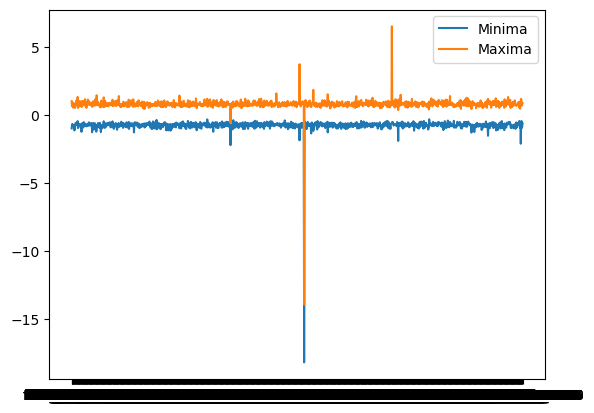

In [344]:
minima, maxima, large_distance_cols= min_max_variance(train_df_feature,1)

plt.plot(minima, label='Minima')
plt.plot(maxima, label='Maxima')
plt.legend()
plt.show()

##### Scaling the data

As the range of the data is not standardized, a scaling technique was applied to make the data comparable across features. Initially, the MinMaxScaler was used to scale the data to a specific range.

**<font color=blue>step 12</font>**

In [125]:
X_train_df_feature = train_df_feature.iloc[:, 1:]
y_train_df_feature = train_df_feature.iloc[:, 0]
#Sclaing only the training data for feature selection
scaled_X_train_df_feature= scale_MinMax_df(X_train_df_feature)
scaled_X_train_df_feature = pd.DataFrame(data=scaled_X_train_df_feature, columns=X_train_df_feature.columns)

## Feature Selection

The subsequent step is feature selection, where the aim is to extract the most informative and valuable features for making predictions from the dataset. Including all available features may result in redundancy and potentially harm the model's performance, while also increasing computational complexity. Therefore, various methods of feature selection are explored to identify the most appropriate one to choose.

In [70]:
#helper for Feature selection   
def grid_search_cv_function(X, y, feature_selector, classifier, param_grid):
    # Define the pipeline
    pipeline = Pipeline([
        ('feature_selection', feature_selector),
        ('classifier', classifier)
    ])

    # Define the scoring metric
    scoring_metric = make_scorer(roc_auc_score)

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=scoring_metric)
    grid_search.fit(X, y)

    # Print the best hyperparameters and the corresponding cross-validation score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Cross-validation score:", grid_search.best_score_)
    
    return grid_search.best_params_


Mutual Information Gain is a feature selection technique that measures the information shared by a feature with the target variable and helps to identify the most relevant features for the model

In [154]:
def bar_chart_horizontal(feature):
    plt.figure(figsize=(10, 8))
    feature.plot(kind='barh', color='teal')
    plt.xlabel('Mutual Information Gain')
    plt.ylabel('Features')
    plt.show()

fetaures with highest info gain


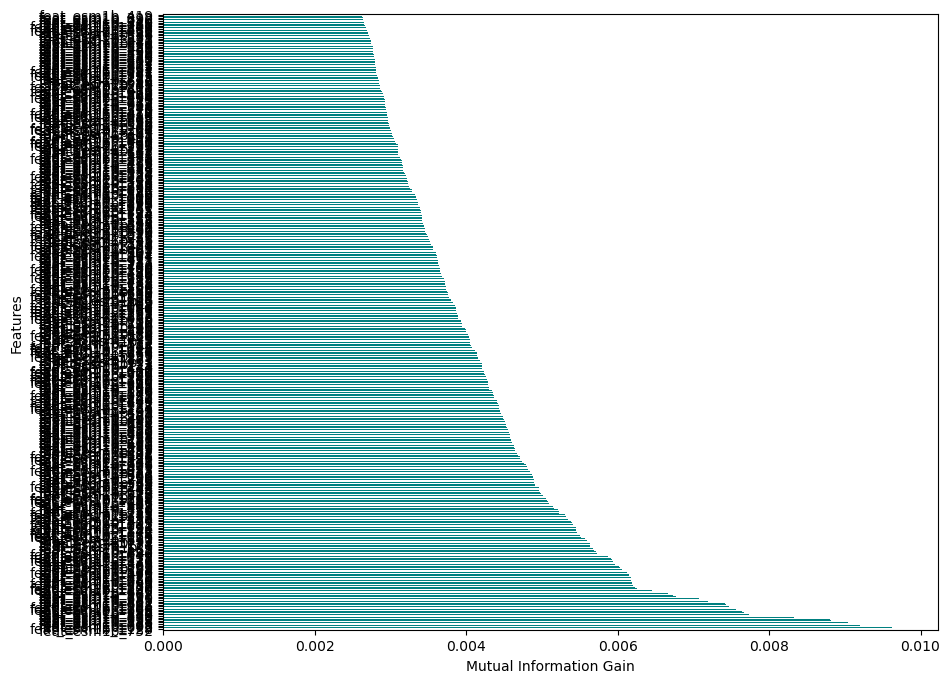

fetaures with lowest info gain


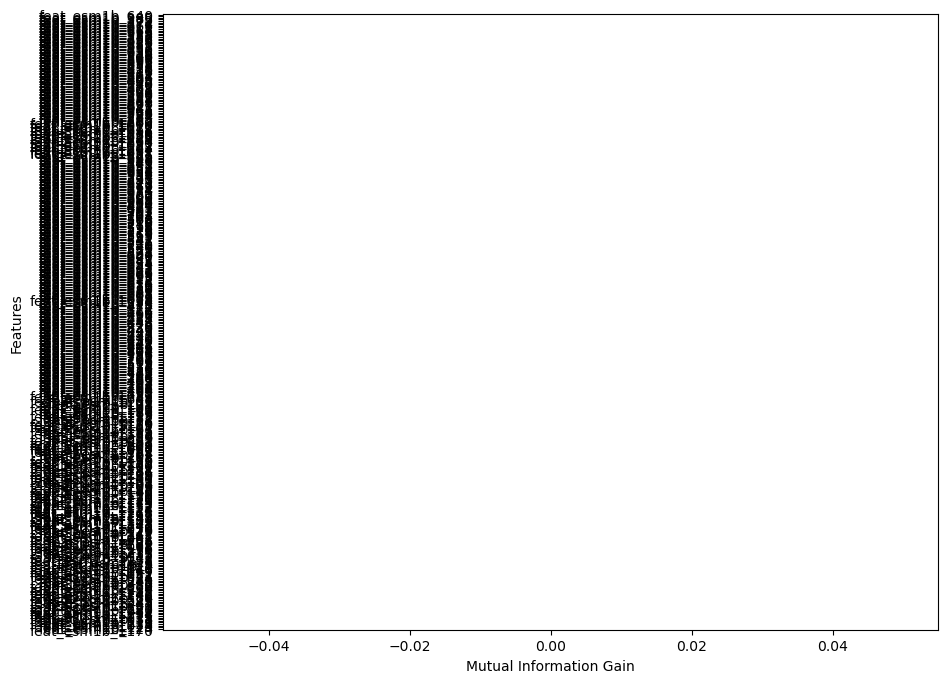

['feat_esm1b_1170',
 'feat_esm1b_124',
 'feat_esm1b_125',
 'feat_esm1b_1074',
 'feat_esm1b_228',
 'feat_esm1b_116',
 'feat_esm1b_1071',
 'feat_esm1b_38',
 'feat_esm1b_1075',
 'feat_esm1b_1173',
 'feat_esm1b_1254',
 'feat_esm1b_1172',
 'feat_esm1b_1082',
 'feat_esm1b_220',
 'feat_esm1b_1251',
 'feat_esm1b_53',
 'feat_esm1b_43',
 'feat_esm1b_1248',
 'feat_esm1b_1085',
 'feat_esm1b_213',
 'feat_esm1b_54',
 'feat_esm1b_1186',
 'feat_esm1b_1246',
 'feat_esm1b_1245',
 'feat_esm1b_215',
 'feat_esm1b_1189',
 'feat_esm1b_214',
 'feat_esm1b_1069',
 'feat_esm1b_236',
 'feat_esm1b_33',
 'feat_esm1b_246',
 'feat_esm1b_249',
 'feat_esm1b_1054',
 'feat_esm1b_11',
 'feat_esm1b_1052',
 'feat_esm1b_1051',
 'feat_esm1b_122',
 'feat_esm1b_1049',
 'feat_esm1b_1048',
 'feat_esm1b_121',
 'feat_esm1b_4',
 'feat_esm1b_1045',
 'feat_esm1b_3',
 'feat_esm1b_1278',
 'feat_esm1b_1181',
 'feat_esm1b_1042',
 'feat_esm1b_12',
 'feat_esm1b_15',
 'feat_esm1b_235',
 'feat_esm1b_1271',
 'feat_esm1b_130',
 'feat_esm1b_1175

In [155]:
#Check Mutual Information Gain for feature sleection
importances = mutual_info_classif(scaled_X_train_df_feature, y_train_df_feature)
feat_importances = pd.Series(importances, X_train_df_feature.columns)
feat_importances = feat_importances.sort_values(ascending=False)
k = len(feat_importances[feat_importances == 0])
top_k_features = feat_importances[:k]
print('fetaures with highest info gain')
bar_chart_horizontal(top_k_features)

bottom_k_features = feat_importances.tail(k) #features with the lowest mutual information gain, 0.0 can be dropped
print('fetaures with lowest info gain')
bar_chart_horizontal(bottom_k_features)
bottom_k_features = list(bottom_k_features.index)
bottom_k_features

Chi2 feature selection is a statistical method used to select the most important features from a dataset by evaluating the relationship between the features and the target variable. It is based on the chi-square statistic.

In [349]:
feature_selector = SelectKBest(chi2)
classifier = LogisticRegression()

param_grid = {
    'feature_selection__k': [5, 10, 15, 25, 35, 45, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700],
    }

best_params = grid_search_cv_function(scaled_X_train_df_feature, y_train_df_feature,  feature_selector, classifier, param_grid)
best_params

Best hyperparameters: {'feature_selection__k': 75}
Cross-validation score: 0.5372687225921011


{'feature_selection__k': 75}

In [350]:
#Chi squared for Feature selection
X_cat = scaled_X_train_df_feature.astype(int)
chi2_features = SelectKBest (chi2, k = 75)
X_kbest_features = chi2_features.fit_transform(X_cat, y_train_df_feature)
print('Original feature number:', X_cat.shape[1])
print('Reduced feature number: ', X_kbest_features.shape[1])#questionable result

mask = chi2_features.get_support()
feature_names = X_cat.columns
selected_feature_names = feature_names[mask]
print("Selected features: ", selected_feature_names)
#print("Transformed data with selected features: ")
#print(X_kbest_features)

Original feature number: 1280
Reduced feature number:  75
Selected features:  Index(['feat_esm1b_1017', 'feat_esm1b_1024', 'feat_esm1b_1025',
       'feat_esm1b_1030', 'feat_esm1b_1032', 'feat_esm1b_1038',
       'feat_esm1b_1040', 'feat_esm1b_1048', 'feat_esm1b_1055',
       'feat_esm1b_1056', 'feat_esm1b_1057', 'feat_esm1b_1061',
       'feat_esm1b_1068', 'feat_esm1b_1071', 'feat_esm1b_1074',
       'feat_esm1b_1082', 'feat_esm1b_1083', 'feat_esm1b_1087',
       'feat_esm1b_1088', 'feat_esm1b_1091', 'feat_esm1b_1101',
       'feat_esm1b_1102', 'feat_esm1b_1103', 'feat_esm1b_1105',
       'feat_esm1b_1108', 'feat_esm1b_1116', 'feat_esm1b_1119',
       'feat_esm1b_1121', 'feat_esm1b_1124', 'feat_esm1b_1129',
       'feat_esm1b_1131', 'feat_esm1b_1135', 'feat_esm1b_1136',
       'feat_esm1b_1137', 'feat_esm1b_1138', 'feat_esm1b_1142',
       'feat_esm1b_1147', 'feat_esm1b_1153', 'feat_esm1b_1157',
       'feat_esm1b_1164', 'feat_esm1b_1166', 'feat_esm1b_1167',
       'feat_esm1b_1168', 

To identify potential redundant columns in a dataset, highly correlated columns can be checked. Any that are highly correlated can then be dropped 

In [351]:
#Check for highly correlated features
cor = train_df_feature.corr()
#plt.figure(figsize = (10,65))
#sns.heatmap(cor[(cor > 0.9) | (cor < -0.9)], annot = True, cmap='coolwarm')

mask = np.triu(np.ones_like(cor, dtype=bool))
high_corr_features = [(i, j) for i in range(cor.shape[0]) for j in range(i+1, cor.shape[1]) if cor.values[i,j] > 0.6 and mask[i,j]]
for pair in high_corr_features:
    print(train_df_feature.columns[pair[0]], "--", train_df_feature.columns[pair[1]], ":", cor.values[pair[0], pair[1]])

feat_esm1b_305 -- feat_esm1b_908 : 0.6351163049769823
feat_esm1b_450 -- feat_esm1b_1020 : 0.6221641109945835
feat_esm1b_659 -- feat_esm1b_908 : 0.8275563413348


Variance threshold is used to identify and remove low-variance features from a dataset. The features with a very low variance may not contain useful information and therefore be dropped from modelling

In [354]:
v_threshold = VarianceThreshold(threshold=0.01)# 0.1 removed all feature, 0.02,0.03 removes over 1000 features
v_threshold.fit(scaled_X_train_df_feature)
filtered_features = np.array(X_train_df_feature.columns)[~v_threshold.get_support()]
print(len(filtered_features))

355


Mean absolute difference (MAD) feature selection is used to identify and select important features from a dataset based on their Mean absolute difference values. The MAD value of a feature is the average absolute difference between the feature values and their mean. Based on the important features can be selected for modelling

1236

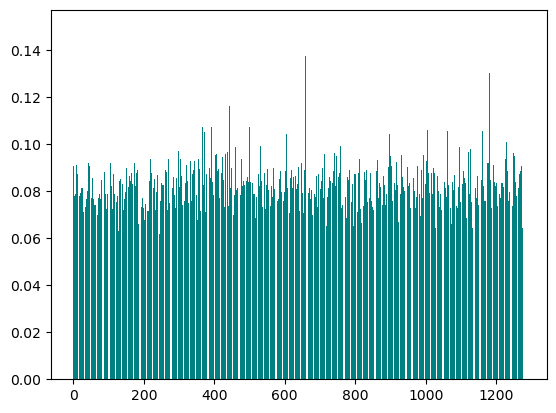

In [355]:
mean_abs_diff = np.sum(np.abs(scaled_X_train_df_feature -np.mean(scaled_X_train_df_feature, axis =0 )), axis = 0)/scaled_X_train_df_feature.shape[0]
plt.bar(np.arange(scaled_X_train_df_feature.shape[1]), mean_abs_diff, color = 'teal')
k = 1280
sorted_indices = np.argsort(mean_abs_diff)[:k]
sorted_mean_abs_diff = mean_abs_diff[sorted_indices]
selected_features_mad = np.where(sorted_mean_abs_diff < 0.1)[0]
selected_feature_names_mad = scaled_X_train_df_feature.columns[sorted_indices[selected_features_mad]].tolist()
len(selected_feature_names_mad)

After applying traditional feature selection methods, Boruta has been employed to identify and rank important features in a dataset by utilizing a random forest model. It is highly effective at handling datasets with high-dimensional and noisy data, which can aid in the selection of crucial features.

In [356]:
#takes a long time to run 30 mins, ran with random state for classifier. dont rerun

#print("start time:", datetime.datetime.now())
forest = RandomForestClassifier(
   n_jobs = -1, 
   max_depth = 5,
   random_state = 42
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 10
)
boruta.fit(np.array(scaled_X_train_df_feature), np.array(y_train_df_feature))
green_area = scaled_X_train_df_feature.columns[boruta.support_].to_list()
blue_area = scaled_X_train_df_feature.columns[boruta.support_weak_].to_list()
#print("End time:", datetime.datetime.now())
print('features in the green area:', green_area)
print('features in the blue area:', blue_area) #del these features.

features in the green area: ['feat_esm1b_1', 'feat_esm1b_2', 'feat_esm1b_5', 'feat_esm1b_9', 'feat_esm1b_12', 'feat_esm1b_16', 'feat_esm1b_18', 'feat_esm1b_22', 'feat_esm1b_24', 'feat_esm1b_29', 'feat_esm1b_30', 'feat_esm1b_34', 'feat_esm1b_37', 'feat_esm1b_38', 'feat_esm1b_41', 'feat_esm1b_44', 'feat_esm1b_46', 'feat_esm1b_48', 'feat_esm1b_50', 'feat_esm1b_51', 'feat_esm1b_52', 'feat_esm1b_53', 'feat_esm1b_54', 'feat_esm1b_55', 'feat_esm1b_58', 'feat_esm1b_60', 'feat_esm1b_63', 'feat_esm1b_66', 'feat_esm1b_69', 'feat_esm1b_70', 'feat_esm1b_73', 'feat_esm1b_75', 'feat_esm1b_76', 'feat_esm1b_78', 'feat_esm1b_79', 'feat_esm1b_80', 'feat_esm1b_81', 'feat_esm1b_82', 'feat_esm1b_87', 'feat_esm1b_88', 'feat_esm1b_89', 'feat_esm1b_90', 'feat_esm1b_91', 'feat_esm1b_92', 'feat_esm1b_93', 'feat_esm1b_95', 'feat_esm1b_98', 'feat_esm1b_101', 'feat_esm1b_103', 'feat_esm1b_105', 'feat_esm1b_110', 'feat_esm1b_111', 'feat_esm1b_112', 'feat_esm1b_114', 'feat_esm1b_115', 'feat_esm1b_116', 'feat_esm1b_11

In [358]:
len(blue_area)

366

Another technique to select features used is Principal Component Analysis (PCA). It is a widely used dimensionality reduction technique that transforms a high-dimensional dataset into a lower-dimensional space while retaining most of the variability of the original data. It is particularly useful when the datasets is large, as it can simplify the data without losing important information.

**<font color=blue>step 13</font>**

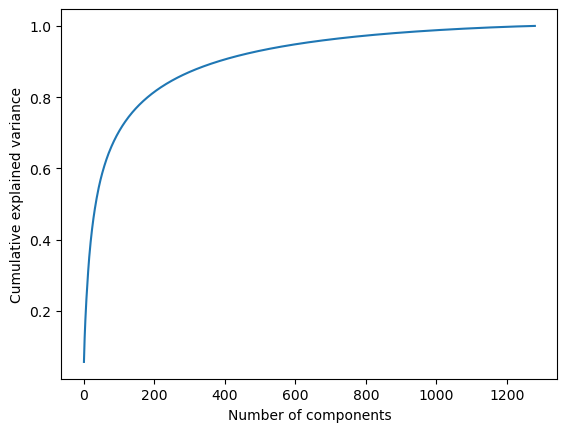

In [126]:
pca = PCA()
pca.fit(scaled_X_train_df_feature)
variance_ratios = pca.explained_variance_ratio_
plt.plot(np.cumsum(variance_ratios))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

**<font color=blue>step 14</font>**

In [127]:
loadings = pca.components_[0]
abs_loadings = np.abs(loadings)
sorted_indices = abs_loadings.argsort()[::-1][:1280]
important_columns = scaled_X_train_df_feature.columns[sorted_indices]
important_loadings = loadings[sorted_indices]

selected_columns_PCA = [col for col, loading in zip(important_columns, important_loadings) if loading > 0]

len(selected_columns_PCA)


643

## Preliminary Modeling

The next stage of the workflow is to build a prelimanry model to check which of the feature selection has good performance and identify any potential issues with the data. During this stage, the focus is on exploring and understanding the data, selecting appropriate features, and identifying relevant machine learning algorithms to build the pipeline

**<font color=blue>step 15</font>**

In [128]:
#helper functions for preliminary modelling
def plot_roc_curve(y_true, y_pred):
    y_prob = y_pred[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    

def classification_metrics(clf_type, clf_class, features, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    metrics_dict = {'type': clf_type, 'class': clf_class, 'features': features, 'accuracy': accuracy, 'f1': f1, 'mcc': mcc, 'roc_auc': roc_auc}
    return pd.DataFrame(metrics_dict, index=[0])
    
def evaluate_model(y_test, y_pred, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) curve for ' + model_name)
    plt.legend(loc="lower right")
    plt.show()

    print('AUC score:', roc_auc)
    print('Classification report:\n', classification_report(y_test, y_pred))


In preliminary modeling, the training data is split into training and testing datasets to fit the model and evaluate its performance. The distribution of the training data is noted, and the data is manually split to ensure that the model is trained and tested on representative subsets of the data.

In [423]:
data_distribution(train_df,'Info_cluster','Class')

   Info_cluster     Total%    Class1%   Class-1%  Class1_DS%  Class-1_DS%
0             8  99.322832  60.799768  39.200232   99.647343    98.823673
1           198   0.103256  72.093023  27.906977    0.122836     0.073140
2           225   0.573912  24.267782  75.732218    0.229821     1.103188


**<font color=blue>step 16</font>**

In [129]:
#split the training data (60%) into trian and test for prelimary modelling
#train_df_pm,test_df_pm = split_data(train_df,'Info_cluster','Class',2) 
#the helper funciton worked well on level 2 data with a particular seed and the data was split and distribution was fairly 
#consistent but it didnt work well for level 3 and therefor this split is also manually done

train = [8]
test =  [198, 225]
train_df_pm, test_df_pm = split_data(train_df,train,test)


Class distribution in train set:
 1    0.607998
-1    0.392002
Name: Class, dtype: float64
Total percentage in train set: 99.32%

Class distribution in test set:
-1    0.684397
 1    0.315603
Name: Class, dtype: float64
Total percentage in test set: 0.68%


After splitting the training data into training and testing sets for preliminary modeling, various feature selection methods were employed to identify those with the best performance. This was done to determine the optimal combination of features and model for the preliminary modeling phase.

 * Trail 1  Mutual Information Gain for feature selection
 * Trail 2  Chi squared for Feature selection
 * Trail 3  Variance Threshold for feature selection
 * Trail 4  BorutaPy for feature selection
 * Trail 5  Mean Absolute Difference for feature selection
 * Trail 6  PCA for feature selection
 
 The commented code below shows the different feature selection methods that were tried. Based on their performance, the best method was selected and paired with a model under various sampling techniques. The code for the best-performing method is left uncommented, while the others are commented out.

In [384]:
# #IG based Feature selection
# train_df_pm = train_df.drop(bottom_k_features, axis=1) # based on IG 
# test_df_pm = test_df.drop(bottom_k_features, axis=1) # based on IG 

#Chi sq based FS
# keep_columns = set(selected_feature_names).intersection(set(train_df.columns))
# keep_columns.update([ 'Class'])
# train_df_pm = train_df_pm[keep_columns]
# test_df_pm = test_df_pm[keep_columns]

##variance threshold based FS
# train_df_pm = train_df_pm.drop(filtered_features, axis=1) # based on variance threshold 
# test_df_pm = test_df_pm.drop(filtered_features, axis=1) # based on variance threshold

#Boruta based FS
# train_df_pm = train_df_pm.drop(blue_area, axis=1) # based on boruta 
# test_df_pm = test_df_pm.drop(blue_area, axis=1) # based on boruta

# #MAD based FS
# keep_columns = set(selected_feature_names_mad).intersection(set(train_df_pm.columns))
# keep_columns.update(['Class'])
# train_df_pm = train_df_pm[keep_columns]
# test_df_pm = test_df_pm[keep_columns]

**<font color=blue>step 16</font>**

In [130]:
#PCA based Feature selection
keep_columns = set(selected_columns_PCA).intersection(set(train_df_pm.columns))
keep_columns.update(['Class'])
train_df_pm = train_df_pm[keep_columns]
test_df_pm = test_df_pm[keep_columns]

#Dependant and Independant variables speration
# #chi sq based/MAD based/PCA based
X_train_df_feature_pm = train_df_pm.drop('Class', axis=1)
y_train_df_feature_pm = train_df_pm['Class']
X_test_df_feature_pm = test_df_pm.drop('Class', axis=1)
y_test_df_feature_pm = test_df_pm['Class']
#IG based/Boruta based/variancethreshold
# train_df_feature_pm = train_df_pm.iloc[:, 13:]
# test_df_feature_pm = test_df_pm.iloc[:, 13:]
# X_train_df_feature_pm = train_df_feature_pm.iloc[:, 1:]
# y_train_df_feature_pm = train_df_feature_pm.iloc[:, 0]
# X_test_df_feature_pm = test_df_feature_pm.iloc[:, 1:]
# y_test_df_feature_pm = test_df_feature_pm.iloc[:, 0]

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

In [78]:
# dtc = DecisionTreeClassifier(random_state=42)
# #rfc = RandomForestClassifier(n_estimators=100,random_state=42)
# #lr = LogisticRegression(random_state=42)
# #svm = SVC(kernel='linear',random_state=42)
# #nb = GaussianNB()
# knn = KNeighborsClassifier(n_neighbors=5)
# #gb = GradientBoostingClassifier(n_estimators=100,random_state=42)
# #classifiers = [(dtc, 'unscaled', 'DT','PCA'), (rfc, 'unscaled', 'RF', 'PCA'), (lr, 'unscaled', 'LR', 'PCA'), (svm, 'unscaled', 'SVM', 'PCA'),(nb,'unscaled','NB','PCA'),(gb,'unscaled','GB','PCA'),(knn,'unscaled','KNN','PCA')]
# classifiers = [(dtc, 'unscaled', 'DT','PCA'), (knn,'unscaled','KNN','PCA')]
# results = []
# for clf, clf_type, clf_class, features in classifiers:
#     y_pred = clf.fit(X_train_df_feature_pm, y_train_df_feature_pm).predict(X_test_df_feature_pm)
#     results.append(classification_metrics(clf_type, clf_class, features, y_test_df_feature_pm, y_pred))

# df_results = pd.concat(results, ignore_index=True)

In [60]:
# #XGboost # rerun along with above
# y_train_binary = (y_train_df_feature_pm + 1) // 2
# y_test_binary = (y_test_df_feature_pm + 1) // 2
# dtrain = xgb.DMatrix(X_train_df_feature_pm, label=y_train_binary)
# params = {
#     'max_depth': 3,
#     'eta': 0.1,
#     'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'seed': 42
# }
# num_rounds = 100
# model = xgb.train(params, dtrain, num_rounds)
# dtest = xgb.DMatrix(X_test_df_feature_pm)
# y_pred_prob = model.predict(dtest)
# y_pred_binary = (y_pred_prob >= 0.5).astype(int)
# results.append(classification_metrics('unscaled', 'XGB','PCA', y_test_df_feature_pm, y_pred))
# df_results = pd.concat(results, ignore_index=True)
# #print(df_results)


As the data range was not standardized, the decision was made to rescale it using the MinMax scaler as specified in the coursework. However, to explore alternative options, the RobustScaler was also tested, which rescales the data based on the median and interquartile range, while accounting for outliers. Despite this, it was found that the MinMax scaler produced better performance and was therefore chosen for the data scaling.

In [97]:
#scaling using minmax
# MMscaler = MinMaxScaler()
# scaled_X_train_df_feature_pm= MMscaler.fit_transform(X_train_df_feature_pm)
# scaled_X_train_df_feature_pm = pd.DataFrame(data=scaled_X_train_df_feature_pm, columns=X_train_df_feature_pm.columns)
# scaled_X_test_df_feature_pm= MMscaler.transform(X_test_df_feature_pm)
# scaled_X_test_df_feature_pm = pd.DataFrame(data=scaled_X_test_df_feature_pm, columns=X_test_df_feature_pm.columns)

**<font color=blue>step 17</font>**

In [131]:
#scaling using Standardscaler
stdscaler=StandardScaler()
scaled_X_train_df_feature_pm = stdscaler.fit_transform(X_train_df_feature_pm)
scaled_X_train_df_feature_pm = pd.DataFrame(data=scaled_X_train_df_feature_pm, columns=X_train_df_feature_pm.columns)
scaled_X_test_df_feature_pm= stdscaler.transform(X_test_df_feature_pm)
scaled_X_test_df_feature_pm = pd.DataFrame(data=scaled_X_test_df_feature_pm, columns=X_test_df_feature_pm.columns)

In [471]:
#scaling using robust
# scaled_X_train_df_feature_pm_rs= scale_robust_df(X_train_df_feature_pm)
# scaled_X_train_df_feature_pm_rs = pd.DataFrame(data=scaled_X_train_df_feature_pm_rs, columns=X_train_df_feature_pm.columns)
# scaled_X_test_df_feature_pm_rs= scale_robust_df(X_test_df_feature_pm)
# scaled_X_test_df_feature_pm_rs = pd.DataFrame(data=scaled_X_test_df_feature_pm_rs, columns=X_test_df_feature_pm.columns)

In [98]:
#features ='Boruta'
#features ='IG'
#features ='MAD'
#features ='PCA'
#features ='VT'
#features ='CHI'

In [99]:
# #testing with scaled data
# trail = 'MMScaled'
# #trail = 'RobustScaled'
# dtc = DecisionTreeClassifier(random_state=42)
# #rfc = RandomForestClassifier(n_estimators=100,random_state=42)
# #lr = LogisticRegression(random_state=42)
# #svm = SVC(kernel='linear',random_state=42)
# #nb = GaussianNB()
# knn = KNeighborsClassifier(n_neighbors=5)
# #gb = GradientBoostingClassifier(n_estimators=100,random_state=42)
# #classifiers = [(dtc, trail , 'DT',features), (rfc, trail, 'RF', features), (lr, trail, 'LR',features), (svm, trail, 'SVM', features),(nb,trail,'NB',features),(gb,trail,'GB',features),(knn,trail,'KNN',features)]
# classifiers = [(dtc, 'unscaled', 'DT','PCA'), (knn,'unscaled','KNN','PCA')]
# #results = [] #ignoring the unscaled results
# for clf, clf_type, clf_class, features in classifiers:
#     y_pred = clf.fit(scaled_X_train_df_feature_pm, y_train_df_feature_pm).predict(scaled_X_test_df_feature_pm)
#     results.append(classification_metrics(clf_type, clf_class, features, y_test_df_feature_pm, y_pred))

# df_results = pd.concat(results, ignore_index=True)

In [529]:
# y_train_binary = (y_train_df_feature_pm + 1) // 2
# y_test_binary = (y_test_df_feature_pm + 1) // 2
# dtrain = xgb.DMatrix(scaled_X_train_df_feature_pm, label=y_train_binary)
# params = {
#     'max_depth': 3,
#     'eta': 0.1,
#     'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'seed': 42
# }
# num_rounds = 100
# model = xgb.train(params, dtrain, num_rounds)
# dtest = xgb.DMatrix(scaled_X_test_df_feature_pm)
# y_pred_prob = model.predict(dtest)
# y_pred_binary = (y_pred_prob >= 0.5).astype(int)
# results.append(classification_metrics(trail, 'XGB',features, y_test_df_feature_pm, y_pred))
# #df_results = pd.concat(results, ignore_index=True)
# print(df_results)


In Level 2 data, after comparing various feature selection methods and classification models in preliminary modeling, it was found that PCA and Information Gain performed the best. Similarly, LR and KNN exhibited the compartively better performance among the classification models, followed by SVM without sampling the data. Below is the high perfroming models in Level 2 data

|Type|Class|Features|Accuracy|F1|MCC|ROC_AUC|
|----|-----|--------|--------|--|---|------|
|scaled|LR|PCA|0.621762|0.569745|0.258715|0.624791|
|MinMaxUS|KNN|IG|0.576857|0.463895|0.182705|0.581881|
|unscaled|SVM|IG|0.580311|0.629008|0.159948|0.577655|
|MinMaxScaled|DT|VT|0.588350|0.417582|0.138196|0.561498|
|MinMaxOS|KNN|PCA|0.552677|0.390588|0.141582|0.558931|

Similarly, in Level 3 data based on the comparison between different feature selection methods and modeling, preliminary modeling with PCA FS showed the best performance, followed by MAD. Furthermore, KNN was found to have the best performance, followed by XGB, DT, and RF, without sampling the data.

As both the models exhibited better performance with PCA and KNN, it was chosen as the prelimnary model for Level 3. 

The final results display, after rebalancing the data(appendix results as well as model performance check), is the basis for the aforementioned conclusion and the selection of the feature selection and classification model.

## Data Rebalancing

As previously mentioned, the dataset exhibits class imbalance, where there is an unequal number of instances between class -1 and class 1. This imbalance can create biases and result in models that perform poorly on the underrepresented class. To address this issue, various data rebalancing methods can be employed. These methods aim to adjust the class distribution of the dataset to ensure a more balanced representation of all classes. Some common data rebalancing techniques including undersampling, oversampling, SMOTE, and cost-sensitive rebalancing were tested to check the performance of the model

#### Undersampling

**<font color=blue>step 18</font>**

In [132]:
rus = RandomUnderSampler(random_state=42)
scaled_X_train_df_feature_pm_us, y_train_df_feature_pm_us = rus.fit_resample(scaled_X_train_df_feature_pm, y_train_df_feature_pm)

In [101]:
# #testing with scaled data
# trail = 'MMUS'
# #trail = 'RobustUS'
# dtc = DecisionTreeClassifier(random_state=42)
# #svm = SVC(kernel='linear',random_state=42)
# #rfc = RandomForestClassifier(n_estimators=100,random_state=42)
# knn = KNeighborsClassifier(n_neighbors=5)
# #classifiers = [(dtc, trail, 'DT',features), (rfc, trail, 'RF',features),(knn,trail,'KNN',features)]
# classifiers = [(dtc, trail, 'DT',features), (knn,trail,'KNN',features)]


# for clf, clf_type, clf_class, features in classifiers:
#     y_pred = clf.fit(scaled_X_train_df_feature_pm_us, y_train_df_feature_pm_us).predict(scaled_X_test_df_feature_pm)
#     results.append(classification_metrics(clf_type, clf_class, features, y_test_df_feature_pm, y_pred))

# df_results = pd.concat(results, ignore_index=True)


#### Oversampling

In [162]:
# ros = RandomOverSampler(random_state=42)
# scaled_X_train_df_feature_pm_os, y_train_df_feature_pm_os = ros.fit_resample(scaled_X_train_df_feature_pm, y_train_df_feature_pm)

In [103]:
# #testing with scaled data
# trail = 'MMOS'
# #trail = 'RobustOS'
# dtc = DecisionTreeClassifier(random_state=42)
# #svm = SVC(kernel='linear',random_state=42)
# #rfc = RandomForestClassifier(n_estimators=100,random_state=42)
# knn = KNeighborsClassifier(n_neighbors=5)
# classifiers = [(dtc, trail, 'DT',features),(knn,trail,'KNN',features)]

# for clf, clf_type, clf_class, features in classifiers:
#     y_pred = clf.fit(scaled_X_train_df_feature_pm_os, y_train_df_feature_pm_os).predict(scaled_X_test_df_feature_pm)
#     results.append(classification_metrics(clf_type, clf_class, features, y_test_df_feature_pm, y_pred))

# df_results = pd.concat(results, ignore_index=True)

#### Synthetic Minority Over-sampling (SMOTE)

In [164]:
# smote = SMOTE()
# scaled_X_train_df_feature_pm_sm, y_train_df_feature_pm_sm = smote.fit_resample(scaled_X_train_df_feature_pm, y_train_df_feature_pm)


In [105]:
# #testing with scaled data
# trail = 'MMSM'
# #trail = 'RobustSM'
# dtc = DecisionTreeClassifier(random_state=42)
# #svm = SVC(kernel='linear',random_state=42)
# #rfc = RandomForestClassifier(n_estimators=100,random_state=42)
# knn = KNeighborsClassifier(n_neighbors=5)
# #classifiers = [(dtc, trail, 'DT',features), (svm,trail, 'SVM',features),(knn,trail,'KNN',features)]
# classifiers = [(dtc, trail, 'DT',features),(knn,trail,'KNN',features)]

# for clf, clf_type, clf_class, features in classifiers:
#     y_pred = clf.fit(scaled_X_train_df_feature_pm_sm, y_train_df_feature_pm_sm).predict(scaled_X_test_df_feature_pm)
#     results.append(classification_metrics(clf_type, clf_class, features, y_test_df_feature_pm, y_pred))

# df_results = pd.concat(results, ignore_index=True)

#### Cost-sensitive rebalancing

Cost-sensitive rebalancing could not be applied to all the models tested since it is not supported by some of them. However, we attempted to apply it to the extent possible to assess its impact on the performance of the models.

In [106]:
# trail = 'MMCS'
# #trail = 'RobustCS'
# dtc = DecisionTreeClassifier(random_state=42)
# #svm = SVC(kernel='linear', class_weight='balanced',random_state=42)
# #rfc = RandomForestClassifier(n_estimators=100,random_state=42)


# classifiers = [(dtc, trail, 'DT', features)
#                ]

# for clf, clf_type, clf_class, features in classifiers:
#     class_weights = class_weight.compute_class_weight(class_weight='balanced',
#                                                       classes=np.unique(y_train_df_feature_pm),
#                                                       y=y_train_df_feature_pm)
#     class_weights = dict(zip(np.unique(y_train_df_feature_pm), class_weights))
#     cost_proportions = np.ones(len(y_train_df_feature_pm))
#     for i, label in enumerate(y_train_df_feature_pm):
#         cost_proportions[i] = class_weights[label]
#     y_pred = clf.fit(scaled_X_train_df_feature_pm, y_train_df_feature_pm, sample_weight=cost_proportions).predict(scaled_X_test_df_feature_pm)
#     results.append(classification_metrics(clf_type, clf_class, features, y_test_df_feature_pm, y_pred))

# df_results = pd.concat(results, ignore_index=True)


In [482]:
# trail = 'StdCS'
# #trail = 'RobustCS'
# dtc = DecisionTreeClassifier(random_state=42)
# #svm = SVC(kernel='linear', class_weight='balanced',random_state=42)
# #rfc = RandomForestClassifier(n_estimators=100,random_state=42)

# #classifiers = [(dtc, trail, 'DT', features),
# #               (rfc, trail, 'RF', features)
# #               ]
# classifiers = [(dtc, trail, 'DT', features)
#                ]

# for clf, clf_type, clf_class, features in classifiers:
#     class_weights = class_weight.compute_class_weight(class_weight='balanced',
#                                                       classes=np.unique(y_train_df_feature_pm),
#                                                       y=y_train_df_feature_pm)
#     class_weights = dict(zip(np.unique(y_train_df_feature_pm), class_weights))
#     cost_proportions = np.ones(len(y_train_df_feature_pm))
#     for i, label in enumerate(y_train_df_feature_pm):
#         cost_proportions[i] = class_weights[label]
#     y_pred = clf.fit(scaled_X_train_df_feature_pm, y_train_df_feature_pm, sample_weight=cost_proportions).predict(scaled_X_test_df_feature_pm)
#     results.append(classification_metrics(clf_type, clf_class, features, y_test_df_feature_pm, y_pred))

# df_results = pd.concat(results, ignore_index=True)

# df_results

type class features  accuracy        f1       mcc   roc_auc
0    unscaled    DT       IG  0.513976  0.483949  0.037006  0.518743
1    unscaled    RF       IG  0.498574  0.554937  0.075364  0.534678
2    unscaled    LR       IG  0.583856  0.491460  0.139552  0.569395
3    unscaled   SVM       IG  0.580719  0.502706  0.140404  0.570434
4    unscaled    NB       IG  0.458642  0.355737 -0.111011  0.444359
..        ...   ...      ...       ...       ...       ...       ...
157  MinMaxSM    DT      PCA  0.542553  0.460251  0.117124  0.562875
158  MinMaxSM   SVM      PCA  0.368794  0.453988 -0.016624  0.493451
159  MinMaxSM   KNN      PCA  0.606383  0.343195  0.063503  0.530797
160  MinMaxCS    DT      PCA  0.429078  0.387833 -0.061448  0.467864
161  MinMaxCS    RF      PCA  0.308511  0.465753 -0.111374  0.482709

[162 rows x 7 columns]

Based on the feature selection and data rebalancing methods discussed above, the best performing models identified are as follows

In [509]:
 df_results.sort_values(by=['roc_auc', 'accuracy'], ascending=False).head(5)

type class features  accuracy        f1       mcc   roc_auc
153      MinMaxUS   KNN      PCA  0.634752  0.516432  0.243884  0.630232
114      unscaled   KNN      MAD  0.549645  0.509653  0.192540  0.601356
115      unscaled   XGB      MAD  0.549645  0.509653  0.192540  0.601356
149  MinMaxScaled   KNN      PCA  0.528369  0.501873  0.171153  0.588840
150  MinMaxScaled   XGB      PCA  0.528369  0.501873  0.171153  0.588840

Based on the finding from above, the following are chosen for Model creation.

To evaluate the performance of the selected feature selection, model, and sampling techniques, the chosen configurations on the preliminary dataset was executed to obtain the model's classification report and the ROC curve plot, which would indicate the model's performance.

### Comparison of Model 1 and Model 2

**<font color=blue>step 19</font>** Below code blocks can be independently executed to generate the performance metrics

model 1 - Chosen based on level 2 data

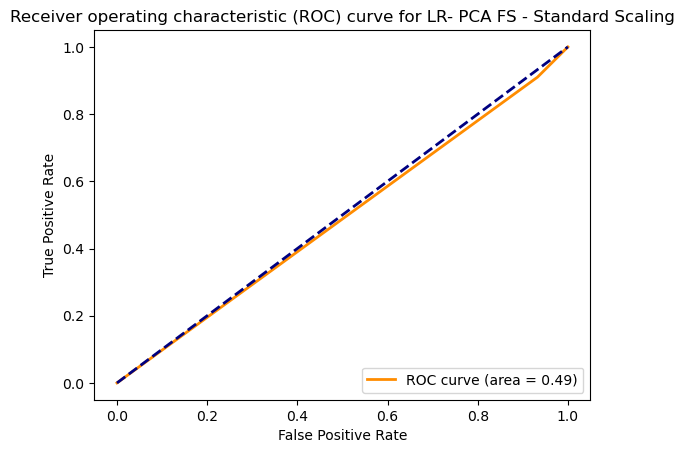

AUC score: 0.48873493625196485
Classification report:
               precision    recall  f1-score   support

          -1       0.62      0.07      0.12       193
           1       0.31      0.91      0.46        89

    accuracy                           0.33       282
   macro avg       0.46      0.49      0.29       282
weighted avg       0.52      0.33      0.23       282



In [133]:
lr = LogisticRegression(random_state=42)
y_pred = lr.fit(scaled_X_train_df_feature_pm, y_train_df_feature_pm).predict(scaled_X_test_df_feature_pm)
evaluate_model(y_test_df_feature_pm, y_pred, 'LR- PCA FS - Standard Scaling')

model 2

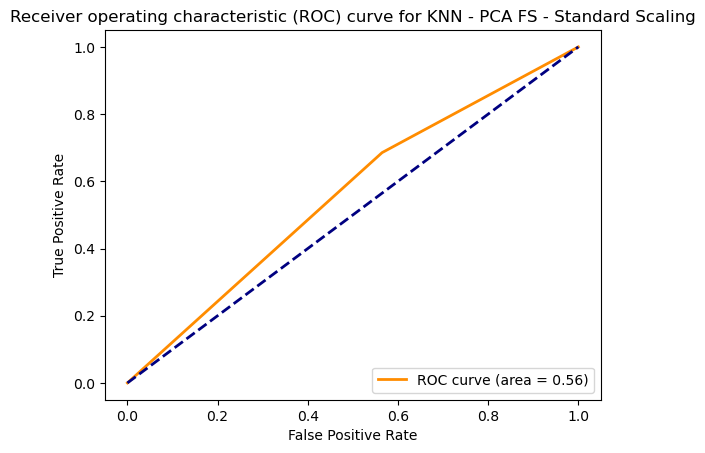

AUC score: 0.5603132095243639
Classification report:
               precision    recall  f1-score   support

          -1       0.75      0.44      0.55       193
           1       0.36      0.69      0.47        89

    accuracy                           0.51       282
   macro avg       0.55      0.56      0.51       282
weighted avg       0.63      0.51      0.53       282



In [134]:
knn = KNeighborsClassifier(n_neighbors=5)
y_pred = knn.fit(scaled_X_train_df_feature_pm, y_train_df_feature_pm).predict(scaled_X_test_df_feature_pm)
evaluate_model(y_test_df_feature_pm, y_pred, 'KNN - PCA FS - Standard Scaling')

**<font color=blue>step 20</font>**

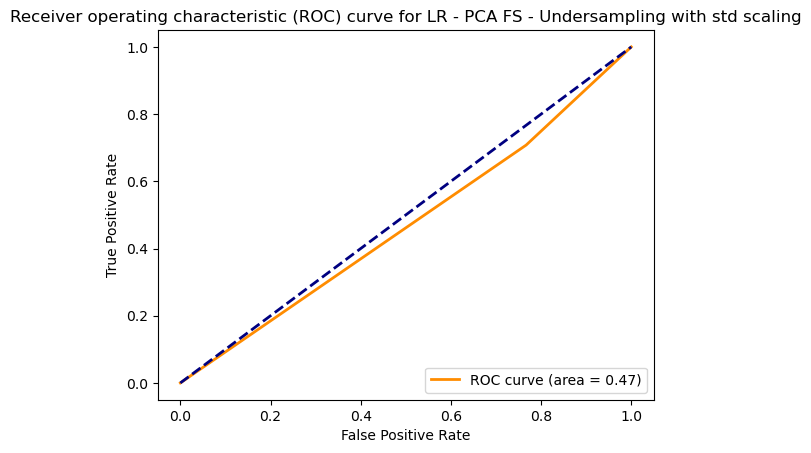

AUC score: 0.47051289515049194
Classification report:
               precision    recall  f1-score   support

          -1       0.63      0.23      0.34       193
           1       0.30      0.71      0.42        89

    accuracy                           0.38       282
   macro avg       0.47      0.47      0.38       282
weighted avg       0.53      0.38      0.37       282



In [135]:
y_pred = lr.fit(scaled_X_train_df_feature_pm_us, y_train_df_feature_pm_us).predict(scaled_X_test_df_feature_pm)
evaluate_model(y_test_df_feature_pm, y_pred, 'LR - PCA FS - Undersampling with std scaling')

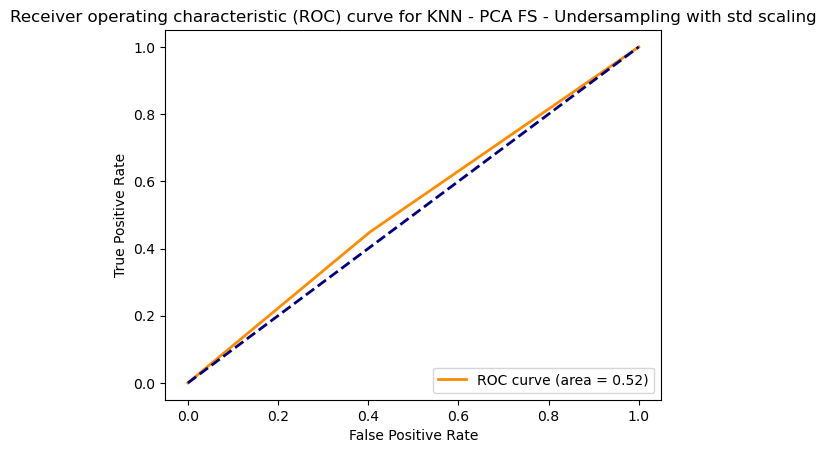

AUC score: 0.5226465622634919
Classification report:
               precision    recall  f1-score   support

          -1       0.70      0.60      0.64       193
           1       0.34      0.45      0.39        89

    accuracy                           0.55       282
   macro avg       0.52      0.52      0.52       282
weighted avg       0.59      0.55      0.56       282



In [136]:
y_pred = knn.fit(scaled_X_train_df_feature_pm_us, y_train_df_feature_pm_us).predict(scaled_X_test_df_feature_pm)
evaluate_model(y_test_df_feature_pm, y_pred, 'KNN - PCA FS - Undersampling with std scaling')

The above graphs for KNN model/LR model indicate the perfromances with standard scaler with Random Under and Over sampling. The performance is comparable. But Model 2 developed based on dataset 3 is better performing than the Model 1.

The performance is slightly better in comparison with level 2 dataset by KNN model shown below
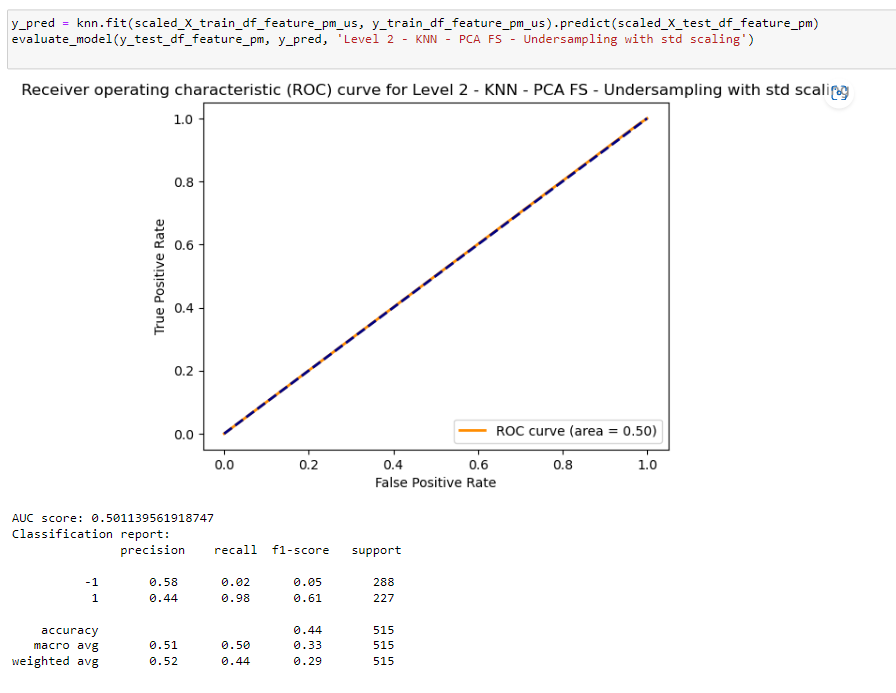

## Hyperparamater Tuning

The subsequent step involves tuning the hyperparameters to enhance model performance. This entails selecting the best values of hyperparameters that were not learned during training, and searching through a range of potential hyperparameter values to identify the combination that produces the best performance on a validation set. The KNN model chosen in the previous step will be used for further tuning and pipeline creation

The following code that are not commented can be run in sequence to reproduce the best params list and fitting the actual model with these params

In [137]:
#Helper function for hyperparameter tuning
def random_search_classifier(classifier, param_distributions, groups, X, y):
    #gkf = GroupKFold(n_splits=4)
    gkf = GroupKFold(n_splits=2)#because of data split, modified for level 3
    rs = RandomizedSearchCV(classifier, param_distributions, scoring='roc_auc', cv=gkf, n_iter=10,random_state=42)
    rs.fit(X, y, groups=groups)
    print("Best hyperparameters: ", rs.best_params_)
        
    return rs.best_estimator_

def class_metrics( model, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    metrics_dict = {'Model': model, 'accuracy': accuracy, 'f1': f1, 'mcc': mcc, 'roc_auc': roc_auc}
    return pd.DataFrame(metrics_dict, index=[0])

    

To tune the hyperparameters, the validation dataset is used. The dataset is split into independent and dependent variables for tuning the model to improve the performance. Before tuning the hyperparameters, the data is scaled to ensure that the optimization process is more stable and accurate. During the hyperparameter tuning process, the column "Info_Cluster" is taken into consideration to ensure that the tuning process incorporates the group criteria. However, this column is excluded from the scaling step to preserve its original values and avoid any potential conflicts.

In [138]:
val_df_feature_ht=val_df.iloc[:, 12:]
#split x and y from val
X_val_df_feature_ht = val_df_feature_ht.drop('Class', axis=1)
y_val_df_feature_ht = val_df_feature_ht['Class']
#scale the validation subset
col_to_exclude = 'Info_cluster'
scaler = StandardScaler()
X_val_df_feature_ht.loc[:, X_val_df_feature_ht.columns != col_to_exclude] = scaler.fit_transform(X_val_df_feature_ht.loc[:, X_val_df_feature_ht.columns != col_to_exclude])
scaled_X_val_df_feature_ht=X_val_df_feature_ht
scaled_X_val_df_feature_ht_us, y_val_df_feature_ht_us = rus.fit_resample(X_val_df_feature_ht, y_val_df_feature_ht)
groups = np.array(scaled_X_val_df_feature_ht_us['Info_cluster'])

Hyperparameters were tuned for all the models identified in both Level 2 and Level 3 datasets. The commented code are for the identified Level 2 models.

In [26]:
knn_param_dist = {
    'n_neighbors': np.arange(1, 21),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}

# dt_param_dist = {
#     'max_depth': [None, 5, 10, 20, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2', None]
# }


# rf_param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

# best_dt = random_search_classifier(dtc,dt_param_dist,groups,scaled_X_val_df_feature_ht_us, y_val_df_feature_ht_us)
best_knn = random_search_classifier(knn,knn_param_dist,groups,scaled_X_val_df_feature_ht_us, y_val_df_feature_ht_us)
# best_rn = random_search_classifier(rfc,rf_param_grid,groups,scaled_X_val_df_feature_ht_us, y_val_df_feature_ht_us)

Best hyperparameters:  {'weights': 'uniform', 'p': 2, 'n_neighbors': 3, 'leaf_size': 50, 'algorithm': 'kd_tree'}


The best hyperparameters identified using RandomizedSearchCV are applied to the training model using GroupKFold cross-validation. GroupKFold is used to ensure that the grouping criteria provided by the Info_cluster column is preserved during the hyperparameter tuning process. This helps to ensure that the model's performance is optimized not only for the overall dataset but also for the specific groups represented in the data.

In [139]:
#dtc = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=2, max_features='auto', max_depth= 20,class_weight='balanced',random_state=42)
#svm = SVC(tol=0.001, shrinking=False, max_iter=1000, kernel='sigmoid', gamma=0.001, degree= 3, coef0=1.0,C=10,random_state=42)
#knn = KNeighborsClassifier(n_neighbors=3,weights='uniform',p=2,leaf_size=50, algorithm='kd_tree')
knn = KNeighborsClassifier(n_neighbors=3,weights='uniform',p=2,leaf_size=50, algorithm='kd_tree')
#rfc = RandomForestClassifier(n_estimators=100,min_samples_split=2, min_samples_leaf= 4, max_features='sqrt', max_depth=20, bootstrap=True,class_weight='balanced',random_state=42)
#classifiers = [(dtc, 'DT'), (rfc, 'RF'),(knn,'KNN')]
results_ht = [] 
classifiers = [(knn,'KNN')]
for clf, clf_type in classifiers:
    y_pred = clf.fit(scaled_X_train_df_feature_pm_us, y_train_df_feature_pm_us).predict(scaled_X_test_df_feature_pm)
    results_ht.append(class_metrics(clf_type, y_test_df_feature_pm, y_pred))

df_results_ht = pd.concat(results_ht, ignore_index=True)
print(df_results_ht)

  Model  accuracy        f1       mcc   roc_auc
0   KNN  0.556738  0.396135  0.058139  0.530855


The performance of the model  is more or less the same after hyperparameter tuning. Although the hyperparameter tuning did not significantly improve the model's performance, it is still important to document and replicate the parameters used to ensure reproducibility of the results. 

Several ensemble models were trialed to check if there was an enhancement in performance. However, the results showed that there was no significant improvement. As a result, it was decided to keep the model simple and use KNN.

In [571]:
# ensemble = VotingClassifier([('dtc', dtc), ('rfc', rfc), ('knn', knn)], voting='hard')
# ensemble.fit(scaled_X_train_df_feature_pm_us, y_train_df_feature_pm_us)
# y_pred = ensemble.predict(scaled_X_test_df_feature_pm)

# results_ht.append(class_metrics('EnsembleUS', y_test_df_feature_pm, y_pred))
# df_results_ht = pd.concat(results_ht, ignore_index=True)
# print(df_results_ht)

        Model  accuracy        f1       mcc   roc_auc
0          DT  0.492908  0.391489 -0.001191  0.499360
1          RF  0.393617  0.463950  0.027768  0.511585
2         KNN  0.634752  0.516432  0.243884  0.630232
3  EnsembleUS  0.510638  0.481203  0.128448  0.566804


In [550]:
# ensemble = BaggingClassifier(base_estimator=knn, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=42, verbose=0)
# ensemble.estimators_ = [knn]
# ensemble.fit(scaled_X_train_df_feature_pm_us, y_train_df_feature_pm_us)
# y_pred = ensemble.predict(scaled_X_test_df_feature_pm)
# results_ht.append(class_metrics('BaggingUS', y_test_df_feature_pm, y_pred))
# df_results_ht = pd.concat(results_ht, ignore_index=True)
# print(df_results_ht)

In [ ]:
# ada = AdaBoostClassifier(base_estimator=knn, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
# ada.fit(scaled_X_train_df_feature_pm_us, y_train_df_feature_pm_us)
# y_pred = ada.predict(scaled_X_test_df_feature_pm)
# results.append(class_metrics('AdaBoostUS', y_test_df_feature_pm, y_pred))
# df_results = pd.concat(results, ignore_index=True)
# print(df_results)

## Model Assessment 

The next step involves evaluating the model's performance on data that it has not been trained on. The objective of model assessment is to ascertain the model's ability to generalize to new, unseen data and to pinpoint any possible drawbacks or limitations of the model. The 10% testing data that had been seperated from the df_main dataframe is used for testing

**<font color=blue>step 21</font>**

In [140]:
#Run the ht helper to run this block
keep_columns = set(selected_columns_PCA).intersection(set(test_df.columns))
keep_columns.update([ 'Class'])
test_df = test_df[keep_columns]
X_test_df_feature_testin = test_df.drop('Class', axis=1)
y_test_df_feature_testin= test_df['Class']
#standard scaler fit for train is transformed for the test
scaled_X_test_df_feature_testin= stdscaler.transform(X_test_df_feature_testin)
scaled_X_test_df_feature_testin = pd.DataFrame(data=scaled_X_test_df_feature_testin, columns=X_test_df_feature_testin.columns)
y_pred = knn.predict(scaled_X_test_df_feature_testin)
print(class_metrics('KNN', y_test_df_feature_testin, y_pred))

  Model  accuracy       f1       mcc  roc_auc
0   KNN  0.521677  0.44562  0.025942  0.51308


The models performance is represented above on unseen data.

## Pipeline creation

The pipeline can be created to integrate all the processes discussed above and apply them to the holdout dataset of the coursework. The pipeline consists of a series of steps, including data scaling, feature selection, and model training. Prior to generating predictions on the holdout dataset, the pipeline can be evaluated using the testing dataset

**<font color=blue>step 22</font>**
  The rest of the code must be run in sequence to reproduce the performance metrics

In [163]:
X_train_df_feature_pipe = train_df_feature.drop('Class', axis=1)
y_train_df_feature_pipe = train_df_feature['Class']
X_val_df_feature_pipe= val_df_feature.drop('Class', axis=1)
y_val_df_feature_pipe = val_df_feature['Class']
X_test_df_feature_pipe= test_df_feature.drop('Class', axis=1)
y_test_df_feature_pipe = test_df_feature['Class']
X_train_df_feature_pipe.reset_index(drop=True, inplace=True)
X_val_df_feature_pipe.reset_index(drop=True, inplace=True)
X_train_df_feature_pipe_cm = pd.concat([X_train_df_feature_pipe, X_val_df_feature_pipe])
y_train_df_feature_pipe_cm = pd.concat([y_train_df_feature_pipe, y_val_df_feature_pipe])

While the pipeline can be improved with additional preprocessing steps such as handling nulls and outliers, the dataset must be explored and the appropriate data cleaning techniques must be determined before incorporating them into the pipeline. This current pipeline has already been trained on cleaned data.

Similarly, custom transformer for for sampling cna also be built and added to the pipeline. In this exercise, existing undersampling has been applied on the data directly

In [171]:
#This is the parameter acheived during the initial tuning
pipe = Pipeline([
    ('scaler', StandardScaler()), #best scaler obtained by tuning
    ('pca', PCA(n_components=10, svd_solver='arpack')), #chosen fs
    ('classifier', KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1, weights='distance')) #chosen classifier
])
# pipe = Pipeline([
#     ('scaler', StandardScaler()), #best scaler obtained by tuning
#     ('pca', PCA(n_components=10, svd_solver='full')), #chosen fs
#     ('classifier', KNeighborsClassifier(leaf_size=5, n_neighbors=5, p=2, weights='uniform')) #chosen classifier
# ])

Tune the hyperparameters of the pipeline and update the pipeline with the best parameter identified as part of the tuning

In [167]:
#Tune the pipeline to get the best params for the pipeline to use.

parameters = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'pca__n_components': [5, 10, 20],
    'pca__svd_solver': ['auto', 'full', 'arpack', 'randomized'],
    'classifier__n_neighbors': [1, 3, 5, 7, 10],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2],
    'classifier__leaf_size': [1, 5, 10, 15]
}
train_df = pd.concat([train_df, val_df], axis=0)
groups = np.array(train_df['Info_cluster'])
best_params = random_search_classifier(pipe,parameters,groups,X_train_df_feature_pipe_cm, y_train_df_feature_pipe_cm)
print(best_params)

Best hyperparameters:  {'scaler': StandardScaler(), 'pca__svd_solver': 'full', 'pca__n_components': 10, 'classifier__weights': 'uniform', 'classifier__p': 2, 'classifier__n_neighbors': 5, 'classifier__leaf_size': 5}
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=10, svd_solver='full')),
                ('classifier', KNeighborsClassifier(leaf_size=5))])


In [172]:
#X_train_df_feature_pipe, y_train_df_feature_pipe = ros.fit_resample(X_train_df_feature_pipe, y_train_df_feature_pipe)
X_train_df_feature_pipe_us, y_train_df_feature_pipe_us = rus.fit_resample(X_train_df_feature_pipe_cm, y_train_df_feature_pipe_cm)
#X_train_df_feature_pipe, y_train_df_feature_pipe = smote.fit_resample(X_train_df_feature_pipe, y_train_df_feature_pipe)

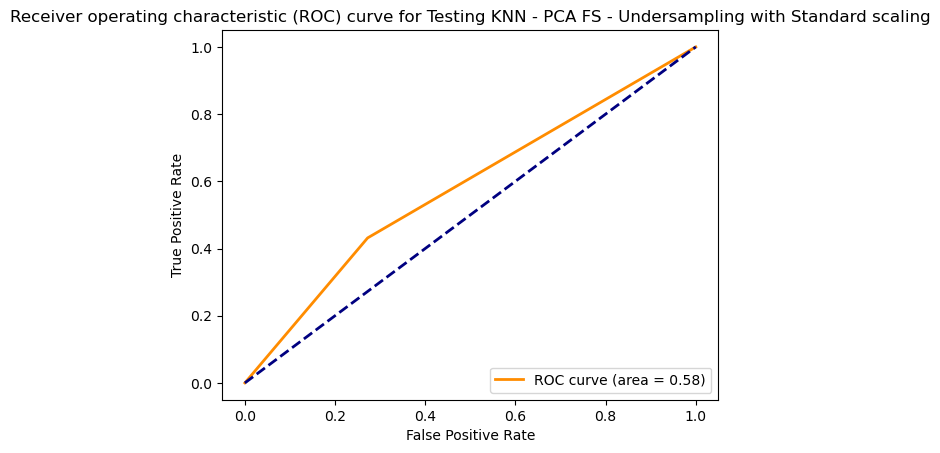

AUC score: 0.5796341675705352
Classification report:
               precision    recall  f1-score   support

          -1       0.64      0.73      0.68      2046
           1       0.53      0.43      0.48      1460

    accuracy                           0.60      3506
   macro avg       0.59      0.58      0.58      3506
weighted avg       0.60      0.60      0.60      3506



In [173]:
pipe.fit(X_train_df_feature_pipe_cm, y_train_df_feature_pipe_cm)
y_pred = pipe.predict(X_test_df_feature_pipe)
evaluate_model(y_test_df_feature_pipe, y_pred, 'Testing KNN - PCA FS - Undersampling with Standard scaling')

The models performance is represented above on unseen testing data. 

Compared to the level 2 dataset, there is a slight improvement in performance. The following is the performance of a pipeline constructed using the same scaler, feature selection, sampling, and model. Despite not being of the same Alphavirus genus, as the amount of data increases, the model's ability to generalize appears to improve slightly.
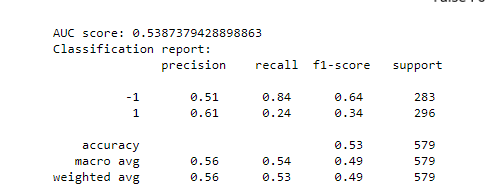

#### Testing with Level 4 dataset

**<font color=blue>step 23</font>**
  The following code can be run in sequence to reproduce the results

In [145]:
df_level4 = pd.read_csv('df_training_level5.csv')#This is the file available in Level4 zip
info_df = df_level4.iloc[:, :13]

In [146]:
df_level4_features = df_level4.iloc[:, 13:]
df_level4_features = df_level4_features.dropna()#drop nulls
X_df_level4_features = df_level4_features.iloc[:, 1:]
y_df_level4_features = df_level4_features.iloc[:, 0]

In [147]:
X_df_level4_features, y_df_level4_features = rus.fit_resample(X_df_level4_features, y_df_level4_features)

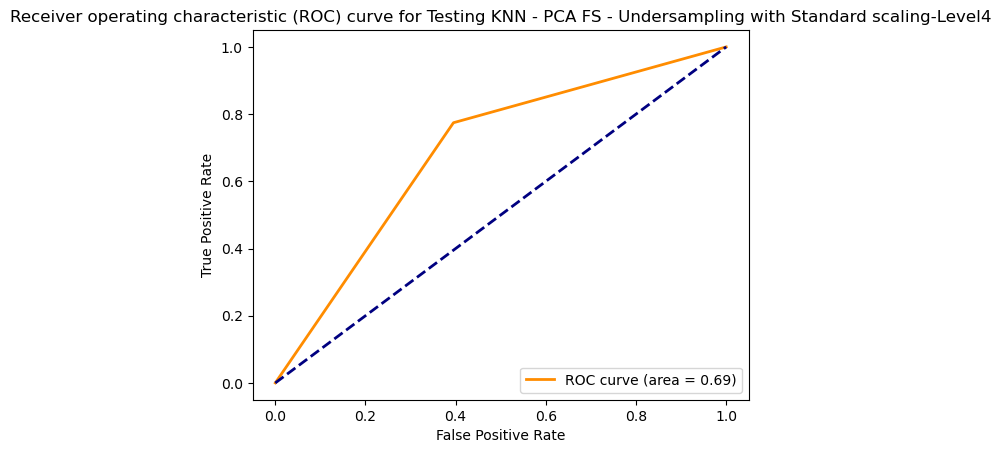

AUC score: 0.6896339864997706
Classification report:
               precision    recall  f1-score   support

          -1       0.73      0.60      0.66     61036
           1       0.66      0.77      0.71     61036

    accuracy                           0.69    122072
   macro avg       0.70      0.69      0.69    122072
weighted avg       0.70      0.69      0.69    122072



In [148]:
y_pred = pipe.predict(X_df_level4_features)
evaluate_model(y_df_level4_features, y_pred, 'Testing KNN - PCA FS - Undersampling with Standard scaling-Level4')

#### Prediction on Holdout dataset

In [178]:
df_holdout = pd.read_csv('df_holdout.csv')
info_df = df_holdout.iloc[:, :13]
x_df_holdout_features = df_holdout.iloc[:, 13:]
x_df_holdout_features

feat_esm1b_0  feat_esm1b_1  feat_esm1b_2  feat_esm1b_3  feat_esm1b_4  \
0        -0.016402      0.385623      0.369218      0.145047      0.162395   
1        -0.016490      0.200233      0.308936     -0.008177     -0.018847   
2        -0.006767      0.174740      0.115804     -0.071989     -0.092009   
3         0.058608      0.168276      0.086705     -0.025356     -0.073806   
4         0.038290      0.147218      0.068720      0.120893      0.078472   
...            ...           ...           ...           ...           ...   
2036      0.165970      0.193738      0.094305      0.041132     -0.200503   
2037      0.055721      0.273031      0.145731      0.013999     -0.213834   
2038      0.053828      0.277536      0.000564     -0.251383      0.022802   
2039      0.071304      0.334002      0.274222     -0.031127     -0.188152   
2040      0.523789      0.230461      0.204165     -0.105705     -0.072959   

      feat_esm1b_5  feat_esm1b_6  feat_esm1b_7  feat_esm1b_8  feat_esm1b_9  \
0        -0.289442      0.072393      0.045740      0.128282      0.344542   
1        -0.509022      0.069447      0.117018     -0.173068      0.229850   
2        -0.187360     -0.293373     -0.144830     -0.265530     -0.064230   
3        -0.000431     -0.170385     -0.051628     -0.157859     -0.021183   
4        -0.094862     -0.217352      0.374518     -0.234353     -0.025302   
...            ...           ...           ...           ...           ...   
2036      0.123520     -0.196257     -0.215846     -0.361902     -0.088894   
2037      0.158513      0.119459     -0.114731     -0.144685      0.052550   
2038      0.006842     -0.188498      0.014508      0.027436      0.104438   
2039      0.121886     -0.231051      0.124551     -0.132090     -0.089186   
2040      0.097564      0.012641      0.219099     -0.062886      0.149522   

      feat_esm1b_10  feat_esm1b_11  feat_esm1b_12  feat_esm1b_13  \
0          0.020675       0.234809      -0.112495       0.237132   
1          0.228758       0.494615      -0.005706       0.016473   
2          0.141894       0.113702       0.083888       0.165797   
3          0.213001       0.271911      -0.076727       0.350955   
4         -0.071490       0.216171       0.075191       0.030444   
...             ...            ...            ...            ...   
2036      -0.060841      -0.015806      -0.182345       0.038219   
2037      -0.065370       0.206292      -0.232511       0.052391   
2038       0.172047       0.033459       0.046133       0.092895   
2039       0.142796      -0.061518       0.050552      -0.118756   
2040       0.300447       0.137951      -0.116794       0.119401   

      feat_esm1b_14  feat_esm1b_15  feat_esm1b_16  feat_esm1b_17  \
0          0.065020       0.205585       0.431026       0.011043   
1          0.224036       0.310620       0.452621       0.042953   
2         -0.022858       0.101056       0.566932      -0.150530   
3         -0.085331       0.174064       0.483475      -0.149528   
4          0.048672      -0.015300       0.862189       0.020560   
...             ...            ...            ...            ...   
2036       0.061782      -0.039024       0.496673       0.187767   
2037       0.079018       0.119200       0.716942       0.036744   
2038       0.116166       0.113225       0.655835       0.218837   
2039      -0.038834       0.039055       0.729553      -0.084414   
2040       0.308787       0.240814       0.449733       0.011613   

      feat_esm1b_18  feat_esm1b_19  feat_esm1b_20  feat_esm1b_21  \
0         -0.012797      -0.165617       0.023091       0.204821   
1         -0.029370       0.014185      -0.009833       0.100604   
2          0.075757      -0.052885      -0.312955       0.117983   
3          0.165013      -0.097429      -0.163766       0.292298   
4         -0.002313       0.027517       0.093384       0.148770   
...             ...            ...            ...            ...   
2036      -0.027431   

In [179]:
y_pred = pipe.predict(x_df_holdout_features)

In [180]:
x_df_holdout_features['Class'] = y_pred
x_df_holdout_features

feat_esm1b_0  feat_esm1b_1  feat_esm1b_2  feat_esm1b_3  feat_esm1b_4  \
0        -0.016402      0.385623      0.369218      0.145047      0.162395   
1        -0.016490      0.200233      0.308936     -0.008177     -0.018847   
2        -0.006767      0.174740      0.115804     -0.071989     -0.092009   
3         0.058608      0.168276      0.086705     -0.025356     -0.073806   
4         0.038290      0.147218      0.068720      0.120893      0.078472   
...            ...           ...           ...           ...           ...   
2036      0.165970      0.193738      0.094305      0.041132     -0.200503   
2037      0.055721      0.273031      0.145731      0.013999     -0.213834   
2038      0.053828      0.277536      0.000564     -0.251383      0.022802   
2039      0.071304      0.334002      0.274222     -0.031127     -0.188152   
2040      0.523789      0.230461      0.204165     -0.105705     -0.072959   

      feat_esm1b_5  feat_esm1b_6  feat_esm1b_7  feat_esm1b_8  feat_esm1b_9  \
0        -0.289442      0.072393      0.045740      0.128282      0.344542   
1        -0.509022      0.069447      0.117018     -0.173068      0.229850   
2        -0.187360     -0.293373     -0.144830     -0.265530     -0.064230   
3        -0.000431     -0.170385     -0.051628     -0.157859     -0.021183   
4        -0.094862     -0.217352      0.374518     -0.234353     -0.025302   
...            ...           ...           ...           ...           ...   
2036      0.123520     -0.196257     -0.215846     -0.361902     -0.088894   
2037      0.158513      0.119459     -0.114731     -0.144685      0.052550   
2038      0.006842     -0.188498      0.014508      0.027436      0.104438   
2039      0.121886     -0.231051      0.124551     -0.132090     -0.089186   
2040      0.097564      0.012641      0.219099     -0.062886      0.149522   

      feat_esm1b_10  feat_esm1b_11  feat_esm1b_12  feat_esm1b_13  \
0          0.020675       0.234809      -0.112495       0.237132   
1          0.228758       0.494615      -0.005706       0.016473   
2          0.141894       0.113702       0.083888       0.165797   
3          0.213001       0.271911      -0.076727       0.350955   
4         -0.071490       0.216171       0.075191       0.030444   
...             ...            ...            ...            ...   
2036      -0.060841      -0.015806      -0.182345       0.038219   
2037      -0.065370       0.206292      -0.232511       0.052391   
2038       0.172047       0.033459       0.046133       0.092895   
2039       0.142796      -0.061518       0.050552      -0.118756   
2040       0.300447       0.137951      -0.116794       0.119401   

      feat_esm1b_14  feat_esm1b_15  feat_esm1b_16  feat_esm1b_17  \
0          0.065020       0.205585       0.431026       0.011043   
1          0.224036       0.310620       0.452621       0.042953   
2         -0.022858       0.101056       0.566932      -0.150530   
3         -0.085331       0.174064       0.483475      -0.149528   
4          0.048672      -0.015300       0.862189       0.020560   
...             ...            ...            ...            ...   
2036       0.061782      -0.039024       0.496673       0.187767   
2037       0.079018       0.119200       0.716942       0.036744   
2038       0.116166       0.113225       0.655835       0.218837   
2039      -0.038834       0.039055       0.729553      -0.084414   
2040       0.308787       0.240814       0.449733       0.011613   

      feat_esm1b_18  feat_esm1b_19  feat_esm1b_20  feat_esm1b_21  \
0         -0.012797      -0.165617       0.023091       0.204821   
1         -0.029370       0.014185      -0.009833       0.100604   
2          0.075757      -0.052885      -0.312955       0.117983   
3          0.165013      -0.097429      -0.163766       0.292298   
4         -0.002313       0.027517       0.093384       0.148770   
...             ...            ...            ...            ...   
2036      -0.027431   

In [181]:
df_holdout_final = pd.concat([info_df, x_df_holdout_features], axis=1)
df_holdout_final = df_holdout_final[['Info_PepID', 'Info_pos', 'Class' ]]
df_holdout_final

Info_PepID  Info_pos  Class
0        P09592.2:2       335      1
1        P09592.2:2       336      1
2        P09592.2:2       337     -1
3        P09592.2:2       338      1
4        P09592.2:2       339      1
...             ...       ...    ...
2036  NP_819008.1:2        91      1
2037  NP_819008.1:2        92     -1
2038  NP_819008.1:2        93     -1
2039  NP_819008.1:2        94      1
2040  NP_819008.1:2        95      1

[2041 rows x 3 columns]

In [182]:
df_holdout_final.to_csv('Abraham_Nissy_CS4850_predictions.csv', index=False)

## Conclusion

In this coursework, the task of detecting linear B cell epitopes of the Alphavirus was addressed using the K Nearest Neighbour model. The model was developed after carefully selecting the most important features through Principal Component Analysis and scaling the data with standard scalar. However, one of the challenges faced during model development was the class imbalance in the data. In order to overcome this issue, data was undersampled to rebalance the minority class. These choices were made after a thorough exploration of 162 different combinations of feature extraction, sampling, and machine learning models. Additionally, after hyperparameter tuning, a number of ensemble models were tested, bringing the total number of trialed methods to almost 165. 

The developed model achieved a good performance in predicting the classes of the samples in the training dataset. In order to assess the model's ability to generalize, it was tested on an unseen testing dataset with the pipeline and achieved a ROC AUC score of 0.58. Additionally, the model's predictive performance was evaluated on Level 4 data, resulting in a notably higher ROC AUC score of 0.69. Finally, the model was applied to predict the classes of the holdout dataset and the predictions were updated in the corresponding file. 

## Future Scope

In order to enhance the model's predictive capabilities, it is crucial to explore additional avenues for improvement. This may be achieved by incorporating more advanced feature extraction techniques, feature engineering or exploring alternative deep learning models. By doing so,  more complex patterns in the data could be potentially uncovered and improve the model's overall performance. Therefore it is important to continue investigating and experimenting with different approaches to further optimize the model's predictive power.

## References

Larsen, J.E.P., Lund, O. and Nielsen, M. (2006) ‘Improved method for predicting linear B-cell epitopes’, Immunome Research, 2(1), p. 2. Available at: https://doi.org/10.1186/1745-7580-2-2.

IEDB.org: Free epitope database and prediction resource (no date). Available at: http://www.iedb.org (Accessed: 10 April 2023).

GenBank Overview (no date). Available at: https://www.ncbi.nlm.nih.gov/genbank/ (Accessed: 10 April 2023).

UniProt (no date). Available at: https://www.uniprot.org/ (Accessed: 10 April 2023).


#### Appendix

Performance of various combination of models/Feature selection and sampling for level 3 data. Similar exercise was done with level 2 data as well. The highlight of the results from level 2 has been discussed in the report earlier in comparison

|Type|Class|Features|Accuracy|F1|MCC|ROC_AUC|
|----|-----|--------|--------|--|---|------|
|ScaledUS|KNN|PCA|0.634751773|0.516431925|0.24388379|0.630232287|
|unscaled|KNN|MAD|0.54964539|0.50965251|0.192540297|0.601356465|
|unscaled|XGB|MAD|0.54964539|0.50965251|0.192540297|0.601356465|
|ScaledScaled|KNN|PCA|0.528368794|0.501872659|0.171152876|0.588839728|
|ScaledScaled|XGB|PCA|0.528368794|0.501872659|0.171152876|0.588839728|
|ScaledScaled|KNN|Boruta|0.531914894|0.5|0.169340259|0.588403097|
|ScaledScaled|XGB|Boruta|0.531914894|0.5|0.169340259|0.588403097|
|ScaledSM|DT|MAD|0.567375887|0.483050847|0.162000817|0.587064097|
|MMSM|DT|PCA|0.542553|0.490119|0.158402|0.584066|
|ScaledOS|KNN|PCA|0.592198582|0.454976303|0.146250382|0.577953077|
|ScaledScaled|LR|IG|0.530804335|0.603709949|0.181343062|0.577692189|
|ScaledSM|KNN|CHI|0.578014184|0.461538462|0.142826738|0.576672294|
|unscaled|KNN|PCA|0.531915|0.484375|0.144307|0.576294|
|unscaled|KNN|PCA|0.531914894|0.484375|0.144306604|0.576293881|
|unscaled|XGB|PCA|0.531914894|0.484375|0.144306604|0.576293881|
|ScaledScaled|KNN|MAD|0.524822695|0.484615385|0.141057357|0.574139838|
|ScaledScaled|XGB|MAD|0.524822695|0.484615385|0.141057357|0.574139838|
|ScaledScaled|SVM|IG|0.525099829|0.60100647|0.171807177|0.57290269|
|unscaled|SVM|IG|0.580718768|0.50270636|0.140404362|0.570434459|
|unscaled|LR|IG|0.583856246|0.491460439|0.139551615|0.569395345|
|ScaledScaled|KNN|CHI|0.517730496|0.480916031|0.131630067|0.568958491|
|ScaledScaled|XGB|CHI|0.517730496|0.480916031|0.131630067|0.568958491|
|ScaledOS|SVM|IG|0.538505419|0.575328084|0.144480073|0.568890853|
|ScaledOS|KNN|CHI|0.556737589|0.458874459|0.124897561|0.567182861|
|unscaled|KNN|PCA|0.51773|0.476923|0.12544|0.565931|
|ScaledScaled|KNN|VT|0.514184397|0.475095785|0.120704835|0.563340513|
|ScaledScaled|XGB|VT|0.514184397|0.475095785|0.120704835|0.563340513|
|ScaledSM|DT|PCA|0.542553191|0.460251046|0.117124432|0.562874774|
|ScaledUS|KNN|CHI|0.574468085|0.439252336|0.115957053|0.561972405|
|MMUS|KNN|PCA|0.58156|0.432692|0.114993|0.561099|
|ScaledSM|SVM|IG|0.515687393|0.588463403|0.140705716|0.560914715|
|unscaled|KNN|PCA|0.514184|0.471042|0.114573|0.560313|
|unscaled|KNN|IG|0.496453901|0.477941176|0.115811468|0.559469057|
|unscaled|XGB|VT|0.496453901|0.477941176|0.115811468|0.559469057|
|ScaledScaled|KNN|IG|0.539361095|0.549763033|0.118747716|0.558834478|
|ScaledScaled|XGB|IG|0.539361095|0.549763033|0.118747716|0.558834478|
|unscaled|VT|Boruta|0.489361702|0.47826087|0.112717008|0.557315014|
|unscaled|XGB|Boruta|0.489361702|0.47826087|0.112717008|0.557315014|
|ScaledUS|KNN|VT|0.567375887|0.435185185|0.106100127|0.556791058|
|ScaledUS|KNN|Boruta|0.570921986|0.426540284|0.100048805|0.553327123|
|unscaled|DT|VT|0.507092199|0.463320463|0.098979647|0.552104558|
|unscaled|KNN|IG|0.537364518|0.530942741|0.100474519|0.550453943|
|unscaled|XGB|IG|0.537364518|0.530942741|0.100474519|0.550453943|
|ScaledOS|KNN|IG|0.550199658|0.49536|0.093439422|0.547326558|
|ScaledUS|KNN|IG|0.554478038|0.481751825|0.091859824|0.546284096|
|ScaledUS|DT|Boruta|0.521276596|0.444444444|0.082713357|0.544303429|
|MMOS|KNN|PCA|0.556738|0.418605|0.080328|0.542964|
|MMSM|KNN|PCA|0.656028|0.302158|0.104281|0.542848|
|ScaledSM|KNN|IG|0.576725613|0.392301392|0.090280546|0.54111832|
|unscaled|SVM|VT|0.475177305|0.463768116|0.080430369|0.540897712|
|ScaledScaled|SVM|VT|0.507092199|0.446215139|0.075190841|0.539995343|
|ScaledSM|SVM|VT|0.563829787|0.405797101|0.07360646|0.539063864|
|unscaled|RF|PCA|0.404255319|0.487804878|0.097016607|0.537521104|
|unscaled|DT|MAD|0.507092199|0.441767068|0.069356977|0.536968039|
|ScaledOS|KNN|MAD|0.570921986|0.391959799|0.067008934|0.5351633|
|unscaled|RF|IG|0.498573873|0.554936709|0.075363954|0.534677754|
|StdOS|KNN|PCA|0.553191|0.40566|0.064326|0.534319|
|ScaledUS|KNN|MAD|0.556737589|0.401913876|0.063698791|0.533882517|
|ScaledUS|DT|VT|0.556737589|0.396135266|0.058139231|0.530855213|
|ScaledSM|KNN|PCA|0.606382979|0.343195266|0.063502574|0.530796996|
|ScaledScaled|RF|IG|0.51711352|0.513645504|0.061354015|0.530748939|
|ScaledOS|SVM|Boruta|0.436170213|0.468227425|0.065153799|0.530564126|
|ScaledSM|KNN|Boruta|0.59929078|0.346820809|0.058216917|0.528642953|
|unscaled|SVM|MAD|0.453900709|0.457746479|0.057115506|0.528380975|
|ScaledSM|SVM|MAD|0.411347518|0.474683544|0.064666901|0.527565931|
|ScaledSM|SVM|Boruta|0.443262411|0.4604811|0.054979545|0.526663562|
|unscaled|DT|Boruta|0.496453901|0.432|0.049145121|0.526168714|
|ScaledCS|DT|Boruta|0.475177305|0.443609023|0.049532281|0.525761192|
|ScaledOS|KNN|Boruta|0.54964539|0.392344498|0.04826661|0.525673866|
|StdUS|KNN|PCA|0.549645|0.386473|0.042672|0.522647|
|ScaledOS|KNN|VT|0.54964539|0.38647343|0.042672001|0.522646562|
|ScaledOS|DT|MAD|0.524822695|0.401785714|0.036559863|0.519648367|
|ScaledScaled|DT|MAD|0.528368794|0.398190045|0.035788021|0.519211737|
|ScaledSM|KNN|VT|0.602836879|0.317073171|0.040232397|0.519124411|
|unscaled|DT|IG|0.513976041|0.483949122|0.037005517|0.518742551|
|ScaledUS|DT|CHI|0.514184397|0.406926407|0.033334878|0.517930954|
|ScaledUS|RF|Boruta|0.539007092|0.386792453|0.033554467|0.517901845|
|unscaled|LR|Boruta|0.418439716|0.460526316|0.0384614|0.517610759|
|ScaledUS|RF|IG|0.507986309|0.493094329|0.034779672|0.517534046|
|unscaled|GB|CHI|0.35106383|0.484507042|0.067601039|0.516824824|
|ScaledScaled|DT|PCA|0.54964539|0.374384236|0.031426364|0.516591954|
|unscaled|SVM|Boruta|0.411347518|0.461038961|0.034492806|0.515456715|
|ScaledSM|DT|Boruta|0.485815603|0.422310757|0.028894297|0.515369389|
|unscaled|DT|PCA|0.489362|0.419355|0.027989|0.514933|
|unscaled|DT|PCA|0.489362|0.419355|0.027989|0.514933|
|unscaled|DT|PCA|0.489362|0.419355|0.027989|0.514933|
|ScaledOS|SVM|VT|0.570921986|0.345945946|0.027407883|0.513972172|
|ScaledSM|DT|VT|0.464539007|0.430188679|0.022903451|0.511934564|
|ScaledScaled|SVM|PCA|0.354609929|0.477011494|0.035094648|0.510333586|
|unscaled|KNN|CHI|0.478723404|0.418972332|0.019196916|0.510188042|
|unscaled|XGB|CHI|0.478723404|0.418972332|0.019196916|0.510188042|
|ScaledCS|DT|IG|0.488020536|0.510499046|0.02029655|0.509941885|
|ScaledOS|DT|PCA|0.507092199|0.398268398|0.01807443|0.509722303|
|ScaledScaled|DT|CHI|0.514184397|0.391111111|0.016460918|0.508849042|
|ScaledUS|RF|CHI|0.496453901|0.403361345|0.014905278|0.50800489|
|ScaledOS|DT|VT|0.475177305|0.417322835|0.01433283|0.507597369|
|ScaledScaled|LR|VT|0.5|0.4|0.014078416|0.50756826|
|unscaled|GB|Boruta|0.329787234|0.482191781|0.047249446|0.50733539|
|unscaled|RF|MAD|0.379432624|0.464831804|0.018640241|0.507277173|
|ScaledSM|DT|IG|0.500570451|0.476218965|0.013766955|0.506962466|
|ScaledCS|DT|VT|0.464539007|0.421455939|0.011205136|0.505879956|
|ScaledScaled|LR|Boruta|0.418439716|0.445945946|0.011573703|0.505501543|
|ScaledScaled|GB|Boruta|0.326241135|0.480874317|0.033418662|0.504744717|
|ScaledScaled|GB|MAD|0.326241135|0.480874317|0.033418662|0.504744717|
|unscaled|RF|VT|0.375886525|0.463414634|0.012117668|0.504686499|
|ScaledUS|DT|IG|0.507986309|0.447646494|0.007506813|0.503801939|
|ScaledOS|SVM|MAD|0.411347518|0.446666667|0.007168921|0.5033475|
|unscaled|GB|VT|0.319148936|0.481081081|0.040510088|0.502590674|
|ScaledScaled|GB|PCA|0.319148936|0.481081081|0.040510088|0.502590674|
|ScaledCS|RF|IG|0.420707359|0.587279008|0.019220576|0.502194392|
|ScaledUS|DT|PCA|0.496453901|0.393162393|0.003627078|0.501950282|
|ScaledUS|DT|MAD|0.521276596|0.372093023|0.003591887|0.501921174|
|ScaledOS|DT|IG|0.483456931|0.495683654|0.003069118|0.501519838|
|ScaledUS|RF|PCA|0.524822695|0.367924528|0.002782566|0.501484543|
|ScaledScaled|DT|IG|0.496292071|0.466465257|0.001861733|0.500942701|
|ScaledSM|KNN|MAD|0.585106383|0.290909091|0.000243919|0.500116435|
|ScaledScaled|NB|IG|0.416428979|0.587998389|0|0.5|
|unscaled|SVM|CHI|0.315602837|0.479784367|0|0.5|
|ScaledScaled|SVM|CHI|0.315602837|0.479784367|0|0.5|
|ScaledScaled|NB|CHI|0.315602837|0.479784367|0|0.5|
|ScaledCS|RF|CHI|0.315602837|0.479784367|0|0.5|
|ScaledScaled|NB|VT|0.315602837|0.479784367|0|0.5|
|ScaledScaled|NB|Boruta|0.315602837|0.479784367|0|0.5|
|unscaled|LR|MAD|0.315602837|0.479784367|0|0.5|
|ScaledScaled|NB|MAD|0.315602837|0.479784367|0|0.5|
|unscaled|LR|PCA|0.315602837|0.479784367|0|0.5|
|ScaledScaled|NB|PCA|0.315602837|0.479784367|0|0.5|
|ScaledSM|SVM|CHI|0.414893617|0.440677966|-0.000243919|0.499883565|
|unscaled|DT|CHI|0.489361702|0.394957983|-0.000379407|0.499796239|
|unscaled|GB|MAD|0.319148936|0.47826087|-0.003955987|0.49956337|
|ScaledScaled|SVM|Boruta|0.393617021|0.450160772|-0.001189999|0.499476044|
|ScaledScaled|DT|VT|0.542553191|0.345177665|-0.00133583|0.499301391|
|ScaledScaled|GB|IG|0.425556189|0.576|-0.004936233|0.498796181|
|StdCS|DT|PCA|0.43617|0.425993|-0.005395|0.497264|
|ScaledCS|RF|VT|0.315602837|0.47696477|-0.03353248|0.496972696|
|ScaledCS|RF|Boruta|0.319148936|0.475409836|-0.024397674|0.496536066|
|ScaledOS|SVM|CHI|0.397163121|0.444444444|-0.008801574|0.496012109|
|StdSM|DT|PCA|0.471631|0.401606|-0.007646|0.495925|
|StdSM|KNN|PCA|0.620567|0.207407|-0.010692|0.49575|
|ScaledCS|RF|MAD|0.326241135|0.472222222|-0.02082244|0.495662805|
|unscaled|SVM|PCA|0.329787234|0.470588235|-0.020428608|0.495226175|
|ScaledScaled|RF|PCA|0.556737589|0.316939891|-0.010790494|0.494527566|
|unscaled|GB|PCA|0.312056738|0.475675676|-0.087847719|0.494382022|
|ScaledSM|SVM|PCA|0.368794326|0.45398773|-0.016623728|0.493450544|
|unscaled|NB|Boruta|0.5|0.373333333|-0.014078416|0.49243174|
|ScaledScaled|SVM|MAD|0.361702128|0.454545455|-0.02295076|0.491296501|
|unscaled|RF|Boruta|0.365248227|0.452599388|-0.023412143|0.490859871|
|ScaledScaled|LR|PCA|0.34751773|0.458823529|-0.029668989|0.490015719|
|ScaledCS|DT|CHI|0.446808511|0.409090909|-0.019348393|0.489899284|
|unscaled|GB|IG|0.441243582|0.533015495|-0.029242441|0.487715422|
|ScaledScaled|GB|VT|0.319148936|0.466666667|-0.060231354|0.487454154|
|ScaledUS|RF|VT|0.517730496|0.346153846|-0.024050471|0.487221284|
|StdOS|DT|PCA|0.457447|0.395257|-0.027205|0.485562|
|ScaledScaled|LR|CHI|0.336879433|0.457971014|-0.047322775|0.485271002|
|unscaled|LR|VT|0.368794326|0.44375|-0.037749356|0.484368632|
|ScaledScaled|RF|VT|0.517730496|0.339805825|-0.029818876|0.48419398|
|ScaledSM|DT|CHI|0.471631206|0.381742739|-0.030179196|0.483815567|
|ScaledOS|SVM|PCA|0.375886525|0.439490446|-0.038201526|0.483495372|
|MMOS|DT|PCA|0.453901|0.393701|-0.032125|0.482971|
|ScaledCS|RF|PCA|0.308510638|0.465753425|-0.111373693|0.482709437|
|unscaled|NB|VT|0.489361702|0.362831858|-0.034159493|0.481632415|
|unscaled|NB|MAD|0.489361702|0.362831858|-0.034159493|0.481632415|
|StdUS|DT|PCA|0.489362|0.362832|-0.034159|0.481632|
|MMUS|DT|PCA|0.489362|0.362832|-0.034159|0.481632|
|ScaledUS|RF|MAD|0.517730496|0.333333333|-0.035622424|0.481166676|
|unscaled|RF|CHI|0.35106383|0.447129909|-0.051959321|0.480497176|
|unscaled|NB|PCA|0.475177305|0.372881356|-0.036559863|0.480351633|
|ScaledScaled|GB|CHI|0.312056738|0.461111111|-0.099640267|0.479245503|
|ScaledOS|DT|Boruta|0.439716312|0.396946565|-0.040728087|0.478663329|
|ScaledScaled|RF|CHI|0.453900709|0.384|-0.04335048|0.476916807|
|MMCS|DT|PCA|0.421986|0.40293|-0.049206|0.474792|
|unscaled|LR|CHI|0.368794326|0.429487179|-0.063392927|0.472259417|
|ScaledCS|DT|PCA|0.429078014|0.3878327|-0.061448164|0.467864004|
|ScaledScaled|LR|MAD|0.411347518|0.398550725|-0.064859507|0.467019852|
|ScaledScaled|RF|MAD|0.535460993|0.251428571|-0.085215203|0.457792397|
|unscaled|DT|PCA|0.439716312|0.362903226|-0.079712318|0.457472201|
|ScaledScaled|RF|Boruta|0.507092199|0.279792746|-0.092081593|0.452203528|
|unscaled|NB|CHI|0.421985816|0.365758755|-0.093617483|0.450573441|
|ScaledScaled|DT|Boruta|0.45035461|0.340425532|-0.092809253|0.450107702|
|unscaled|NB|IG|0.458642327|0.355736592|-0.111011402|0.444359191|
|ScaledOS|DT|CHI|0.429078014|0.348178138|-0.105533978|0.443645573|
|ScaledCS|DT|MAD|0.421985816|0.35059761|-0.109995336|0.441491529|


